In [817]:
library(Seurat)
library(stringr)
library(data.table)

# Human Skin

In [15]:
meta = read.csv("./hSkin_scRNAseq/Skin_6Control_Metadata.csv", row.names = 1)

In [16]:
reannotate_clusters = data.frame(cluster = seq(0, 18),
                                 reannotate = c("Fibroblast", "Keratinocyte", "Endothelial_cell", "Fibroblast", "Fibroblast", "Keratinocyte",
                                                "Pericyte", "Keratinocyte", "Macrophage.DC", "Lymphocyte", "Pericyte", "Keratinocyte",
                                                "Secretory_epithelial", "Smooth_muscle", "Keratinocyte", "Melanocyte", "Neural_cell", "Cornified Env", "B_cell"))

In [17]:
meta$celltype = reannotate_clusters[match(meta$res.0.6, reannotate_clusters$cluster), "reannotate"]

In [21]:
skin.data <- read.csv("./hSkin_scRNAseq/Skin_6Control_rawUMI.csv", row.names = 1)

In [53]:
skin <- CreateSeuratObject(skin.data, meta.data = meta)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”

In [54]:
skin

An object of class Seurat 
32738 features across 8522 samples within 1 assay 
Active assay: RNA (32738 features)

# QC and filter according to text

In [55]:
skin[["percent.mt"]] <- PercentageFeatureSet(skin, pattern = "MT-")

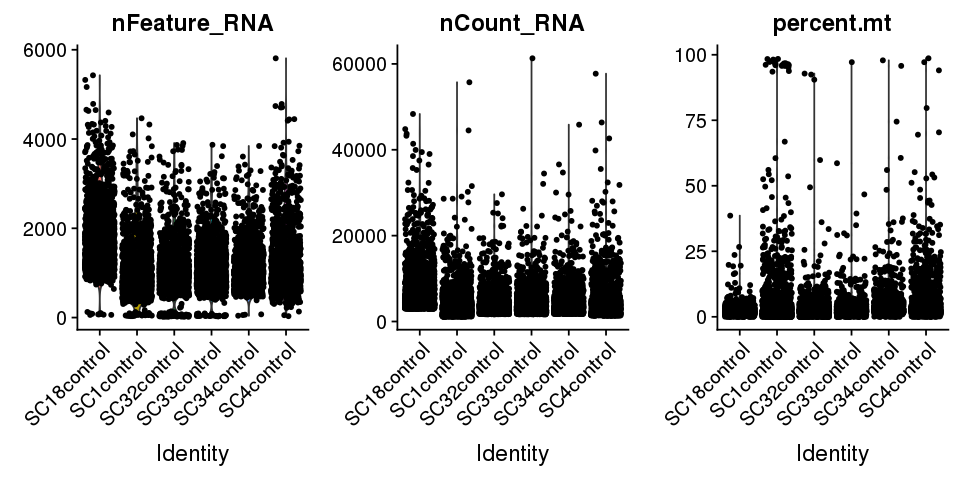

In [56]:
VlnPlot(skin, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

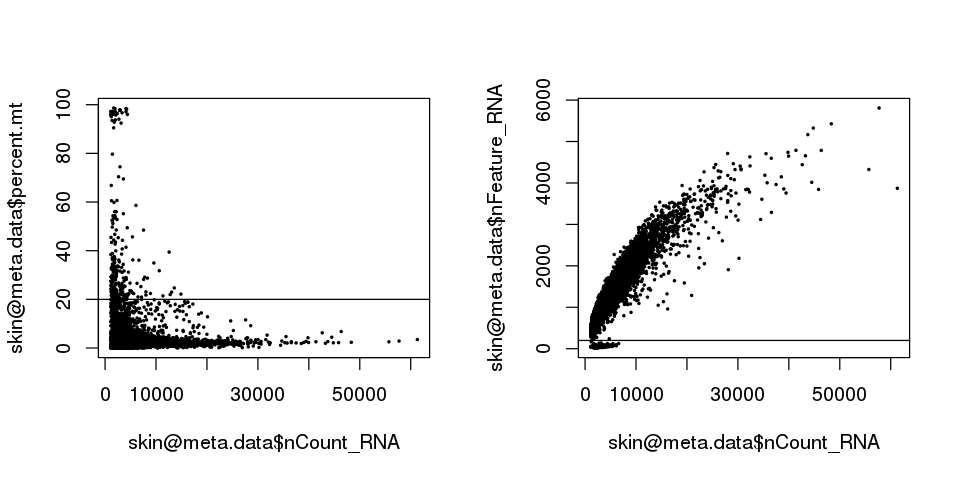

In [57]:
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow = c(1,2))

plot(skin@meta.data$nCount_RNA, skin@meta.data$percent.mt, pch = 19, cex = .25)
abline(h = 20)
plot(skin@meta.data$nCount_RNA, skin@meta.data$nFeature_RNA, pch = 19, cex = .25)
abline(h = 200)

In [58]:
skin <- subset(skin, subset = nFeature_RNA > 200) #personally, I would have filtered on high fraction MT 

# Normalize

In [59]:
skin <- NormalizeData(skin, verbose = FALSE)

In [60]:
skin = FindVariableFeatures(skin, selection.method = "vst", nfeatures = 2000, verbose = FALSE)

In [61]:
skin <- ScaleData(skin, vars.to.regress = c("nUMI", "percent.mito"))

Regressing out nUMI, percent.mito
Centering and scaling data matrix


In [62]:
skin <- RunPCA(skin, npcs = 30, verbose = FALSE)

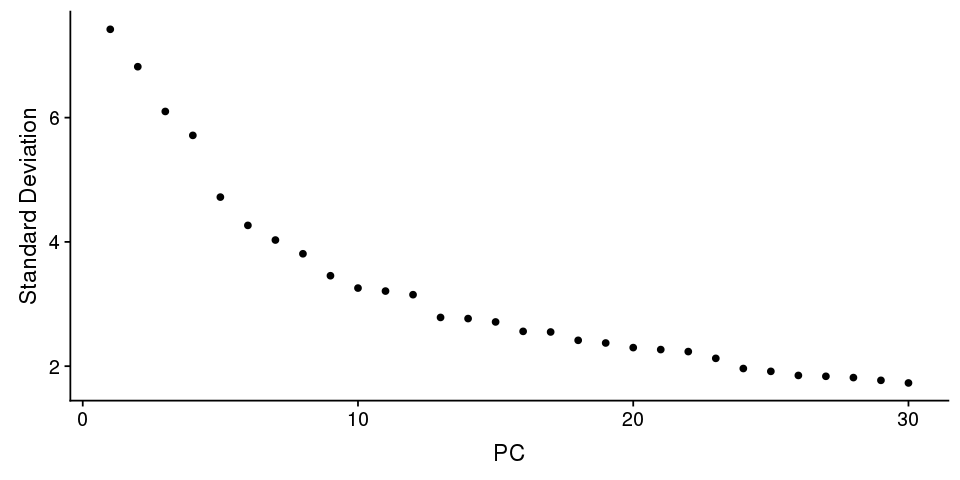

In [64]:
ElbowPlot(skin, ndims = 30)

In [65]:
skin <- RunUMAP(skin, reduction = "pca", dims = 1:24)

# Mouse

In [73]:
facs_annotation = read.csv("../data/annotations_facs.csv")

In [68]:
ReannotateMeta <- function(tiss){
    
    reann.df = facs_annotation[, c("cell", "cell_ontology_class")]
    tiss@meta.data$cell <- rownames(tiss@meta.data)
    temp.meta = tiss@meta.data
    temp.meta = merge(temp.meta, reann.df)
    rownames(temp.meta) = temp.meta$cell
    tiss@meta.data = temp.meta
    
    return(tiss)

}

In [69]:
load("../data/Robjs/facs_Skin_seurat_tiss.robj", verbose = TRUE)

Loading objects:
  tiss


In [70]:
tiss = tiss

In [71]:
tiss

An old seurat object
 16180 genes across 2263 samples

In [74]:
mouse_skin = ReannotateMeta(tiss)

In [75]:
mouse_skin = UpdateSeuratObject(mouse_skin)

Validating object structure
Ensuring keys are in the proper strucutre
Ensuring feature names don't have underscores
Object representation is consistent with the most current Seurat version


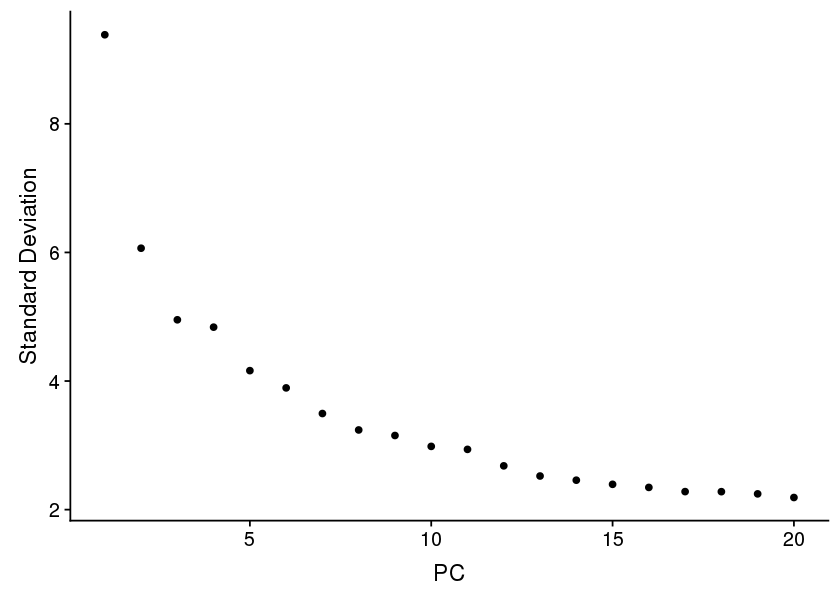

In [84]:
ElbowPlot(mouse_skin)

In [85]:
mouse_skin <- RunUMAP(object = mouse_skin, reduction.use = "pca", dims = 1:12, min_dist = .4, seed = 10) #PCs used based on PCElbowPlot(object = mouse_liver)

In [86]:
PlotUMAPFrazer <- function(tiss, colors){

    
    
    DimPlot(tiss, reduction.use = "umap", do.label = F, group.by = "annotation", pt.size = .6, cols.use = c("#a3a737", "#e48925", "#9e84bb", "#34ade3",  "#500070",  "darkgreen"),
            plot.title = "Initial annotation")
    
    DimPlot(tiss, reduction.use = "umap", do.label = F, group.by = "cell_ontology_class", pt.size = .6, cols.use = colors, plot.title = "Final annotation")
    

    
}

# Plots

### mouse genes
Epidermis is divided into 2 regions (divided by Cd34):

1) interfollicular epidermis (IFE)

* Basal IFE = Krt14, Krt10
* Replicating basal IFE = Top2a
* Intermediate IFE = Krt10

2) hair follicles (HFs)

* Outer bulge = Dkk3
* Inner bulge = Fgf18


In [1907]:
human_skin

An object of class Seurat 
32738 features across 8366 samples within 1 assay 
Active assay: RNA (32738 features)
 2 dimensional reductions calculated: pca, umap

In [1909]:
mouse_skin

An object of class Seurat 
16180 features across 2263 samples within 1 assay 
Active assay: RNA (16180 features)
 3 dimensional reductions calculated: pca, tsne, umap

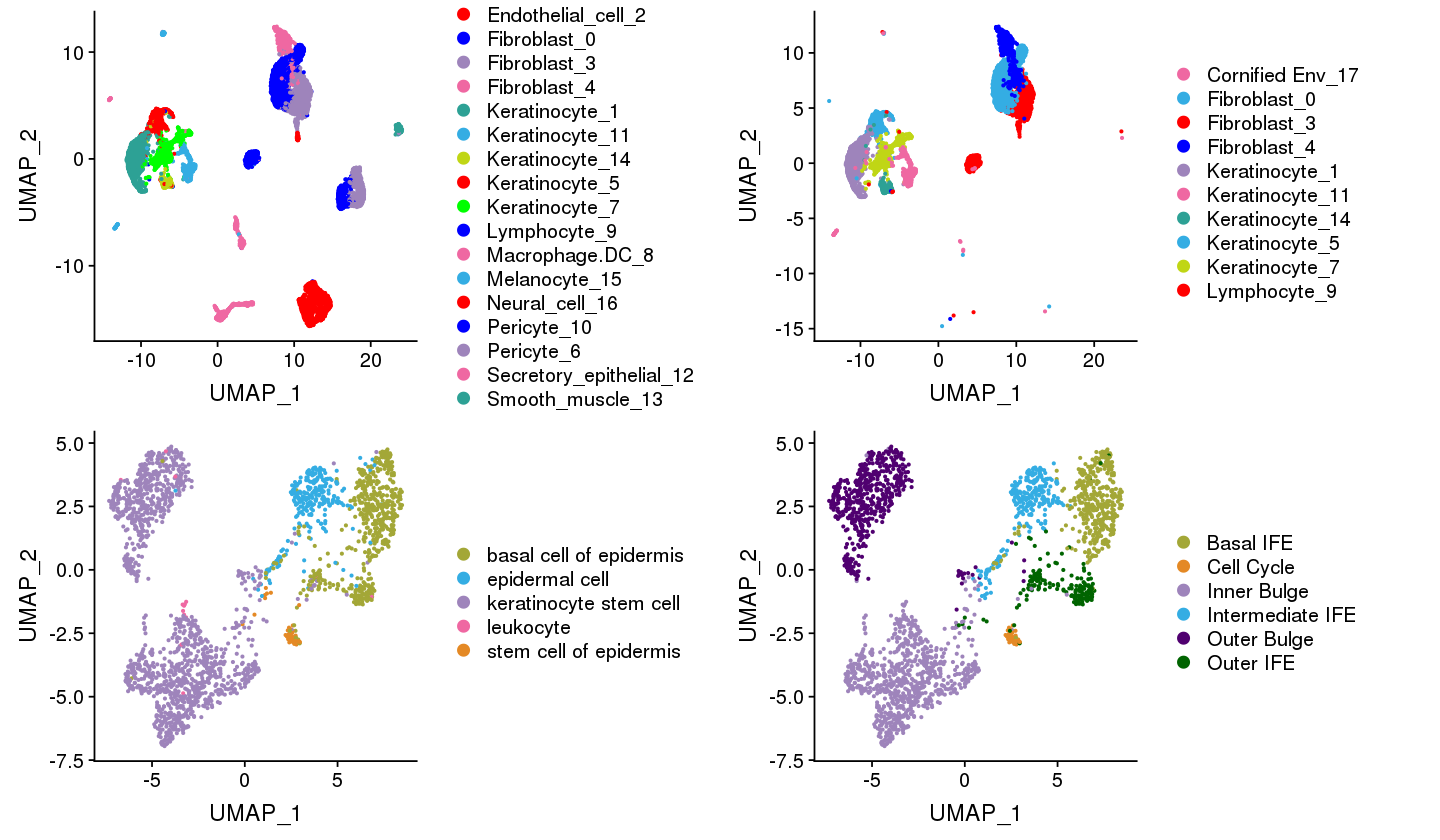

In [778]:
options(repr.plot.width = 12, repr.plot.height = 7)

# p1 <- DimPlot(human_skin, reduction.use = "umap", label = F, group.by = "celltyper", pt.size = .5, cols = human_cols)
p1 <- DimPlot(human_skin, reduction.use = "umap", label = F, group.by = "celltype_cluster", pt.size = .5, , cols = rep(human_cols, 4))
p4 <- DimPlot(human_skin_epidermis, reduction.use = "umap", label = F, group.by = "celltype_cluster", pt.size = .5, , cols = rep(human_cols, 4))

p2 <- DimPlot(mouse_skin, reduction.use = "umap", do.label = F, group.by = "annotation", pt.size = .5,
        cols = c("#a3a737", "#e48925", "#9e84bb", "#34ade3",  "#500070",  "darkgreen"))

p3 <- DimPlot(mouse_skin, reduction.use = "umap", do.label = F, group.by = "cell_ontology_class", pt.size = .5,
        cols = c("#a3a737", "#34ade3", "#9e84bb", "#ef68a2", "#e48925"))

CombinePlots(plots = list(p1, p4,p3, p2))

# Cell Composition

cornified envelope cells = formed beneath the plasma membrane in terminally differentiating stratified squamous epithelia. Very top of the skin. https://jcs.biologists.org/content/114/17/3069

melanocyte = bottom layer of the epidermis. induce pigmentation. https://en.wikipedia.org/wiki/Melanocyte

In [108]:
human_skin <- skin

In [118]:
human_cols <- c("#ef68a2", "#34ade3", "red", "blue", "#9e84bb", "#ef68a2", "#2da195", "#34ade3", "#c0d615", "red", "green", "blue")
mouse_cols <- c("#a3a737", "#34ade3", "#9e84bb", "#ef68a2", "#e48925")

In [109]:
human_skin@meta.data$cell_ontology_class <- human_skin@meta.data$celltype

In [126]:
PlotBarplotFrazer <- function(tiss, colors){
    
    par(mar = c(10, 5, 1, .5))
    counts = as.data.frame(table(tiss@meta.data$cell_ontology_class))

    counts$fraction = (counts$Freq / sum(counts$Freq)) * 100
    counts = counts[order(counts$Var1),]
    counts$color <- colors
    counts = counts[order(counts$fraction),]
    



    barplot(counts$fraction, horiz = F, xlim = c(0, 60), names.arg = counts$Var1, las = 2, col = counts$color,
            border=NA, width = 3, ylab = "Fraction of cells")
    
    
}

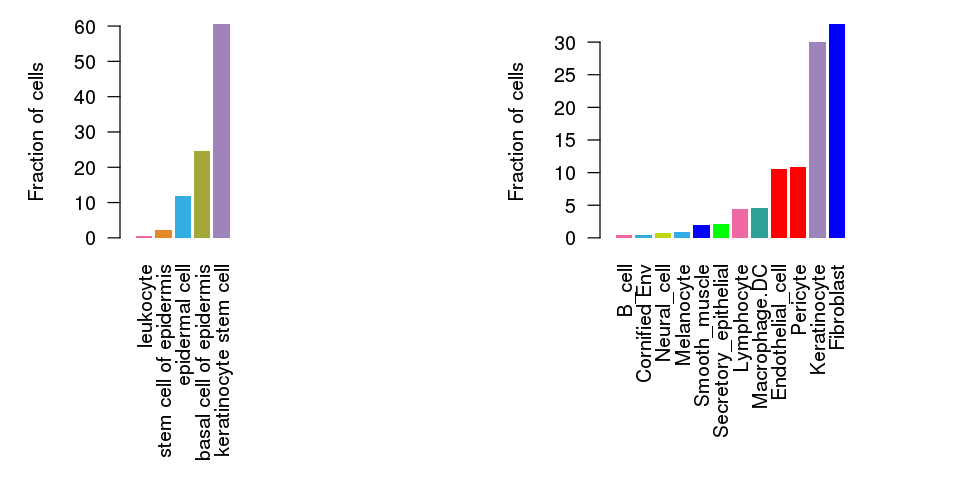

In [127]:
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow = c(1,2))
PlotBarplotFrazer(mouse_skin, mouse_cols)
PlotBarplotFrazer(human_skin, human_cols)

# Get human signature genes from single cell

In [129]:
Idents(object = human_skin) <- "cell_ontology_class"

In [131]:
cts = unique(Idents(object = human_skin))

In [144]:
## NOTE: there are too few schwann cells
for( celltype in cts){
    celltype_name = gsub(" " , "_", celltype)
    assign(paste(celltype_name, "markers", sep = "_"), FindMarkers(human_skin, ident.1 = celltype, ident.2 = NULL, min.pct = 0.25))

}

In [145]:
cts

[1] Keratinocyte         Endothelial_cell     Fibroblast          
 [4] Melanocyte           Pericyte             Macrophage.DC       
 [7] Smooth_muscle        Lymphocyte           Cornified Env       
[10] Secretory_epithelial Neural_cell          B_cell              
12 Levels: Keratinocyte Endothelial_cell Fibroblast Melanocyte ... B_cell

In [146]:
markers = list( Keratinocyte_markers,
                Endothelial_cell_markers,
                Fibroblast_markers,
                Melanocyte_markers,
                Pericyte_markers,
                Macrophage.DC_markers,
                Smooth_muscle_markers,
                Lymphocyte_markers,
                Cornified_Env_markers,
                Secretory_epithelial_markers,
                Neural_cell_markers,
                B_cell_markers
                )


In [147]:
names(markers) <- c("Keratinocyte_markers",
                    "Endothelial_cell_markers",
                    "Fibroblast_markers",
                    "Melanocyte_markers",
                    "Pericyte_markers",
                    "Macrophage.DC_markers",
                    "Smooth_muscle_markers",
                    "Lymphocyte_markers",
                    "Cornified_Env_markers",
                    "Secretory_epithelial_markers",
                    "Neural_cell_markers",
                    "B_cell_markers"
                    )

In [173]:
sig.df = data.frame(genes = NA, celltype = NA)

for( i in seq(1, length(markers))){
    
    ct = str_split_fixed(names(markers[i]), "_marke", 2)[,1]
    temp = as.data.frame(markers[[i]])
    temp = temp[order(temp$p_val_adj), ]
    temp = temp[temp$avg_logFC > 0.25 & temp$p_val_adj < 0.05, ]
    
    if(nrow(temp) > 100){ genes2add = rownames(temp[1:100,])}
    else{ genes2add = rownames(temp[1:nrow(temp),]) }

    sig.df.temp = data.frame(genes = genes2add, celltype = ct)
    sig.df = rbind(sig.df, sig.df.temp)
}

sig.df = sig.df[2:nrow(sig.df),]

In [149]:
geneinfo = read.table("/publicdata/gencode_v19_20151104/gene_info.tsv", header = T)

In [174]:
sig.df$geneid = geneinfo[match(sig.df$genes, geneinfo$gene_name), "gene_id"]

In [175]:
sig.df$dup = duplicated(sig.df$genes)
sig.df = sig.df[sig.df$dup == F, ]

In [177]:
mouse_genes = read.table("../tables/Cibersort_input/Skin_mouse_signature_matrix_200.txt", header = T)

sig.df$inmouse = sig.df$geneid %in% mouse_genes$gene_id



table(sig.df$inmouse, sig.df$celltype)

       
        B_cell Cornified_Env Endothelial_cell Fibroblast Keratinocyte
  FALSE     68            94               92         79           62
  TRUE       6             6                8         21           38
       
        Lymphocyte Macrophage.DC Melanocyte Neural_cell Pericyte
  FALSE         53            70         94          68       85
  TRUE          23            21          4           8       10
       
        Secretory_epithelial Smooth_muscle
  FALSE                   81            74
  TRUE                     8             3

In [178]:
sig.avg_exp = AverageExpression(human_skin, features = unique(sig.df$genes))

Finished averaging RNA for cluster Keratinocyte
Finished averaging RNA for cluster Endothelial_cell
Finished averaging RNA for cluster Fibroblast
Finished averaging RNA for cluster Melanocyte
Finished averaging RNA for cluster Pericyte
Finished averaging RNA for cluster Macrophage.DC
Finished averaging RNA for cluster Smooth_muscle
Finished averaging RNA for cluster Lymphocyte
Finished averaging RNA for cluster Cornified Env
Finished averaging RNA for cluster Secretory_epithelial
Finished averaging RNA for cluster Neural_cell
Finished averaging RNA for cluster B_cell


In [179]:
sig.avg_exp = sig.avg_exp$RNA

In [180]:
sig.avg_exp$gene_id = geneinfo[match(rownames(sig.avg_exp), geneinfo$gene_name), "gene_id"]

In [181]:
rownames(sig.avg_exp) <- NULL

In [182]:
signature_gene_matrix = sig.avg_exp[, c(ncol(sig.avg_exp), 1:(ncol(sig.avg_exp) - 1))]

In [183]:
head(signature_gene_matrix)

gene_id            Keratinocyte Endothelial_cell Fibroblast Melanocyte
1 ENSG00000186847.5  179.53311    1.3518626        1.4779890  42.002736 
2 ENSG00000167768.4   41.10982    0.3012167        0.2699730   2.530025 
3 ENSG00000161249.16  63.07132    0.5413146        0.4959963   3.695263 
4 ENSG00000175793.10  28.69664    0.1979344        0.2427086   5.546384 
5 ENSG00000186395.6   75.67863    2.1842484        2.9268666   9.495361 
6 ENSG00000186081.7   26.06173    0.2082762        0.2379379   5.643691 
  Pericyte  Macrophage.DC Smooth_muscle Lymphocyte Cornified Env
1 2.6534379 2.0602494     8.5537897     1.3448737   1.05666188  
2 0.6410664 0.6063851     0.2953915     0.3311468   0.05020420  
3 1.0611569 0.7743002     0.6621246     0.4902235  85.39830801  
4 0.3200796 0.5187930     0.4334243     0.3443578   0.08447012  
5 2.3182221 1.6878556     1.5435354     1.0194551   2.04285696  
6 0.4534351 0.4262785     0.6819623     0.2701865   0.10237278  
  Secretory_epithelial Neural_cell B_cell   
1 5.43738600           1.22952091  0.2217003
2 0.09991594           0.49444253  0.1343216
3 0.27454335           1.02684609  0.1869085
4 0.24990363           0.06438895  0.0000000
5 1.91030087           2.40183960  2.8075694
6 0.52491661           0.07180174  0.0000000

# GTEx expression of signature genes

In [187]:
gtex_samples   = read.table("/publicdata/gtex_v7/GTEx_v7_Annotations_SampleAttributesDS_V2.txt", header = TRUE, sep = "\t")
gtex_samples_skin = gtex_samples[gtex_samples$SMTS == "Skin", "SAMPID"]

In [188]:
gtex = fread("/publicdata/gtex_v7/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct", header = TRUE, sep = "\t", check.names = FALSE)
gtex           = as.data.frame(gtex)
rownames(gtex) = gtex$Name

In [189]:
gtex_matrix = gtex[ rownames(gtex) %in% signature_gene_matrix$gene_id , colnames(gtex) %in% gtex_samples_skin]

In [190]:
gtex_matrix$gene_id = rownames(gtex_matrix)
gtex_matrix = gtex_matrix[, c(ncol(gtex_matrix), seq(1:(ncol(gtex_matrix)-1)))]
rownames(gtex_matrix) <- NULL

In [193]:
dim(signature_gene_matrix)
dim(gtex_matrix)

[1] 1074   13

[1] 1074 1204

# Prepare tables for CIBERSORT deconvolution

In [192]:
signature_gene_matrix = signature_gene_matrix[signature_gene_matrix$gene_id %in% gtex_matrix$gene_id, ]
gtex_matrix           = gtex_matrix[gtex_matrix$gene_id %in% signature_gene_matrix$gene_id, ]

In [194]:
table(gtex_matrix$gene_id %in% signature_gene_matrix$gene_id)
table(signature_gene_matrix$gene_id %in% gtex_matrix$gene_id)


TRUE 
1074 


TRUE 
1074 

In [195]:
head(signature_gene_matrix)
head(gtex_matrix)

gene_id            Keratinocyte Endothelial_cell Fibroblast Melanocyte
1 ENSG00000186847.5  179.53311    1.3518626        1.4779890  42.002736 
2 ENSG00000167768.4   41.10982    0.3012167        0.2699730   2.530025 
3 ENSG00000161249.16  63.07132    0.5413146        0.4959963   3.695263 
4 ENSG00000175793.10  28.69664    0.1979344        0.2427086   5.546384 
5 ENSG00000186395.6   75.67863    2.1842484        2.9268666   9.495361 
6 ENSG00000186081.7   26.06173    0.2082762        0.2379379   5.643691 
  Pericyte  Macrophage.DC Smooth_muscle Lymphocyte Cornified Env
1 2.6534379 2.0602494     8.5537897     1.3448737   1.05666188  
2 0.6410664 0.6063851     0.2953915     0.3311468   0.05020420  
3 1.0611569 0.7743002     0.6621246     0.4902235  85.39830801  
4 0.3200796 0.5187930     0.4334243     0.3443578   0.08447012  
5 2.3182221 1.6878556     1.5435354     1.0194551   2.04285696  
6 0.4534351 0.4262785     0.6819623     0.2701865   0.10237278  
  Secretory_epithelial Neural_cell B_cell   
1 5.43738600           1.22952091  0.2217003
2 0.09991594           0.49444253  0.1343216
3 0.27454335           1.02684609  0.1869085
4 0.24990363           0.06438895  0.0000000
5 1.91030087           2.40183960  2.8075694
6 0.52491661           0.07180174  0.0000000

gene_id            GTEX-111VG-0008-SM-5Q5BG GTEX-111YS-0008-SM-5Q5BH
1 ENSG00000188290.6    1.86000                  1.32300               
2 ENSG00000187608.5   63.27000                 64.99000               
3 ENSG00000237330.2    0.19680                  0.02783               
4 ENSG00000186891.9    0.09108                  0.30910               
5 ENSG00000162576.12 307.00000                388.90000               
6 ENSG00000179403.10   5.13700                  5.63300               
  GTEX-1122O-0008-SM-5QGR2 GTEX-1128S-0008-SM-5Q5DP GTEX-113IC-0008-SM-5QGRF
1   2.48400                  1.6590                   2.4810                
2  53.96000                 56.8900                  38.9800                
3   0.03396                  0.1899                   0.1770                
4   0.09429                  0.5858                   0.1229                
5 343.40000                536.5000                 433.7000                
6   3.36700                  6.7430                   4.4530                
  GTEX-113JC-0008-SM-5QGR6 GTEX-117XS-0008-SM-5Q5DQ GTEX-117YW-0008-SM-5QGRD
1   3.9210                   0.7012                   2.8400                
2  56.5100                  43.4800                  49.0300                
3   0.0000                   0.0639                   0.0000                
4   0.1191                   0.2957                   0.3881                
5 358.8000                 445.4000                 460.0000                
6   3.8320                   3.0000                   5.9720                
  GTEX-1192W-0008-SM-5QGRE ⋯ GTEX-ZXG5-0126-SM-5GIEU GTEX-ZY6K-1826-SM-5GZXK
1   0.76030                ⋯  16.450                 18.500                 
2  48.50000                ⋯  18.510                 15.810                 
3   0.09594                ⋯   7.699                  3.429                 
4   0.17760                ⋯  41.310                 23.770                 
5 456.10000                ⋯ 105.200                 78.490                 
6   8.58600                ⋯  11.960                 18.100                 
  GTEX-ZYFC-0226-SM-5NQ75 GTEX-ZYFD-0126-SM-5GIDL GTEX-ZYFG-2326-SM-5E44B
1 20.320                  13.250                  12.970                 
2 27.670                  13.340                   7.681                 
3  5.309                   7.144                   3.527                 
4 38.120                  45.870                  24.830                 
5 95.000                  57.840                  45.230                 
6 23.610                  22.330                   6.489                 
  GTEX-ZYT6-0226-SM-5NQ6T GTEX-ZYW4-0126-SM-5E44A GTEX-ZYY3-0126-SM-5GZY5
1  8.732                   30.370                  35.240                
2 12.660                   15.920                   9.912                
3 11.930                    7.615                  12.600                
4 24.370                   29.040                  39.450                
5 35.250                  269.000                 267.400                
6 11.410                   25.740                  11.870                
  GTEX-ZZ64-1726-SM-5GZYB GTEX-ZZPT-0226-SM-5E43X
1 18.470                   26.44                 
2  6.787                   40.86                 
3  9.526                    6.65                 
4 24.390                    5.45                 
5 52.200                  261.30                 
6 15.940                   15.61

In [196]:
write.table(signature_gene_matrix, file = "Skin_human_signature_matrix_100.txt", row.names = F, quote = F, sep = "\t")
write.table(gtex_matrix,           file = "GTEx_skin_signatureFromHuman_mixture_matrix_100.txt", row.names = F, quote = F, sep = "\t")

# Compare mouse and human

In [305]:
mouse_estimates = read.csv("../tables/Cibersort_out/CIBERSORT.Output_Job97_skin_mouse.csv")
human_estimates = read.csv("./CIBERSORT.Output_Job128_skin_100.csv")
human_estimates = human_estimates[human_estimates$Input.Sample %in% mouse_estimates$Input.Sample, ]

mouse_order = mouse_estimates[order(-mouse_estimates$epidermal_cell), "Input.Sample"]
human_order = human_estimates[order(-human_estimates$Endothelial_cell, -human_estimates$Secretory_epithelial, -human_estimates$Fibroblast), "Input.Sample"]

## Bar plot

In [226]:
CiberBarFrazer <- function(ciber, colors, main0, ordered, legy){
    
    rownames(ciber) <- ciber$Input.Sample
    ciber$Input.Sample <- NULL
    ciber = ciber[, seq(1, (ncol(ciber) - 3))]
    ciber = ciber[ordered,]
    nsamples = nrow(ciber)
    ciber = as.data.frame(t(ciber) * 100)

    ciber$color = colors[ match(rownames(ciber), colors$celltypes),  "colors"]
    
    barplot(as.matrix(ciber[, seq(1, (ncol(ciber) - 1))]), las = 2, col = ciber$color, border=NA, names.arg = rep("", ncol(ciber) - 1), 
           ylab = "Fraction clusters", main = main0)

    text(nsamples * .05, legy + 3, paste("n = ", nsamples, sep = ""), pos = 4)

    legend(nsamples * .05, legy, gsub("_", " ", colors$celltypes), bty = "n",
           pch = rep(22, nrow(colors)),
           pt.cex = rep(1.5, nrow(colors)),
           pt.bg = colors$colors )
    
}

In [252]:
mouse_colors = data.frame(celltypes = c('basal_cell_of_epidermis', 'epidermal_cell', 'keratinocyte_stem_cell',
                                       'leukocyte', 'stem_cell_of_epidermis'),
                          colors =     mouse_cols)
               
human_colors = data.frame(celltypes = c('Keratinocyte', "Endothelial_cell", "Fibroblast",
                                       "Melanocyte", "Pericyte", "Macrophage.DC",
                                       "Smooth_muscle", "Lymphocyte", "Cornified.Env",
                                       "Secretory_epithelial", "Neural_cell", "B_cell"),
                          colors =     human_cols)

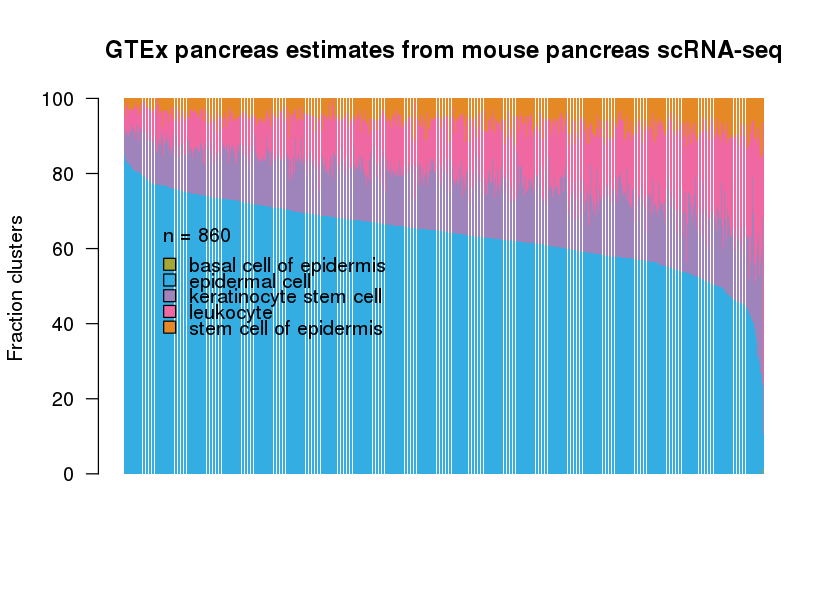

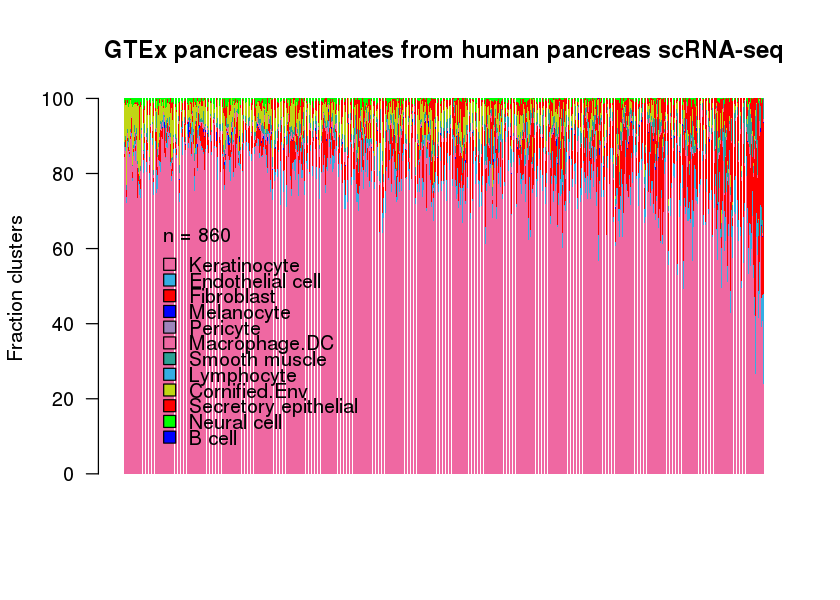

In [306]:
figure_width  =  7
figure_height = 5
options(repr.plot.width = figure_width, repr.plot.height = figure_height)
CiberBarFrazer(mouse_estimates, mouse_colors, "GTEx pancreas estimates from mouse pancreas scRNA-seq", mouse_order, 60)
CiberBarFrazer(human_estimates, human_colors, "GTEx pancreas estimates from human pancreas scRNA-seq", mouse_order, 60)

# Correlation

In [314]:
CorrPlotFrazer <- function(x, y, xmax, main){
    
    plot(x, y, xlim = c(0, xmax), ylim = c(0,xmax), las = 1, pch = 20, cex = 1.5, main = main, xlab = "Estimate from human", ylab = "Estimate from mouse")
    
    text(xmax - (xmax * .5), xmax - (xmax * .2),   round(cor(x, y), 2)) 
    text(xmax - (xmax * .5), xmax - (xmax * .1), (cor.test(x, y, method = "pearson")$p.value)) 
    
    lines(c(-0.1, 1.1), c(-0.1, 1.1))
    
}

In [264]:
mouse_colors = data.frame(celltypes = c('basal_cell_of_epidermis', 'epidermal_cell', 'keratinocyte_stem_cell',
                                       'leukocyte', 'stem_cell_of_epidermis'),
                          colors =     mouse_cols)
               
human_colors = data.frame(celltypes = c('Keratinocyte', "Endothelial_cell", "Fibroblast",
                                       "Melanocyte", "Pericyte", "Macrophage.DC",
                                       "Smooth_muscle", "Lymphocyte", "Cornified.Env",
                                       "Secretory_epithelial", "Neural_cell", "B_cell"),
                          colors =     human_cols)

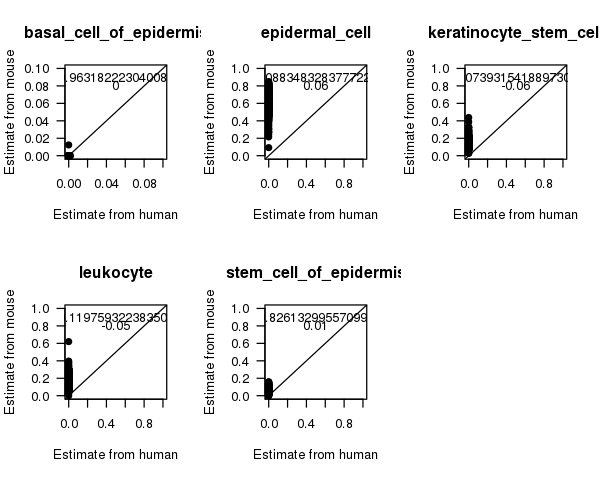

In [271]:
options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$B_cell , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$B_cell , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$B_cell , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$B_cell , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$B_cell , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")



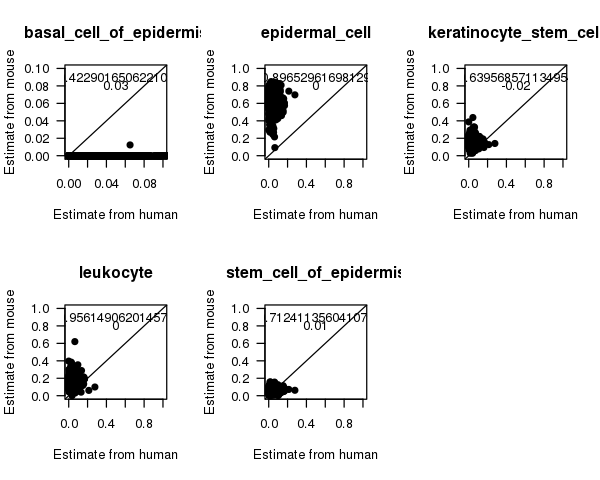

In [272]:
options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Cornified.Env , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Cornified.Env , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Cornified.Env , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Cornified.Env , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Cornified.Env , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")


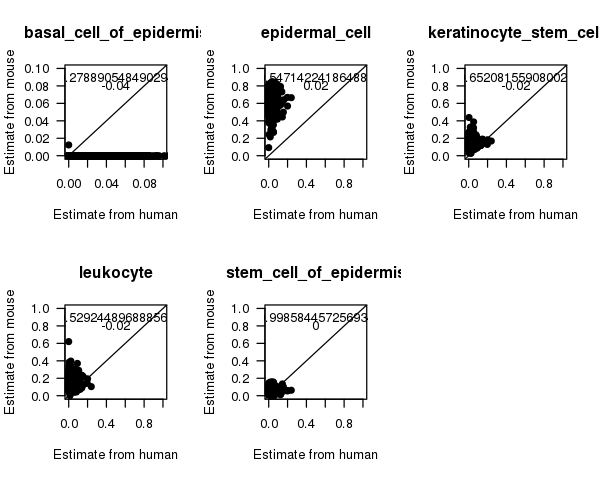

In [273]:
options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Endothelial_cell , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Endothelial_cell , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Endothelial_cell , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Endothelial_cell , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Endothelial_cell , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

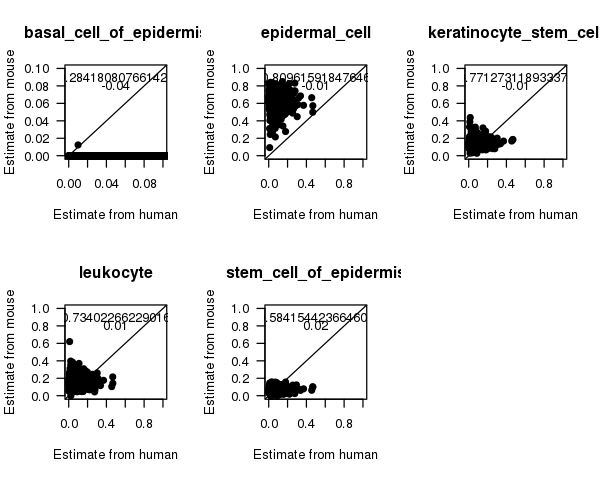

In [274]:
options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Fibroblast , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Fibroblast , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Fibroblast , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Fibroblast , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Fibroblast , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")


	Pearson's product-moment correlation

data:  human_estimates$Keratinocyte + human_estimates$Melanocyte and mouse_estimates$basal_cell_of_epidermis
t = 1.2146, df = 858, p-value = 0.2248
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.02549049  0.10798350
sample estimates:
       cor 
0.04143135 


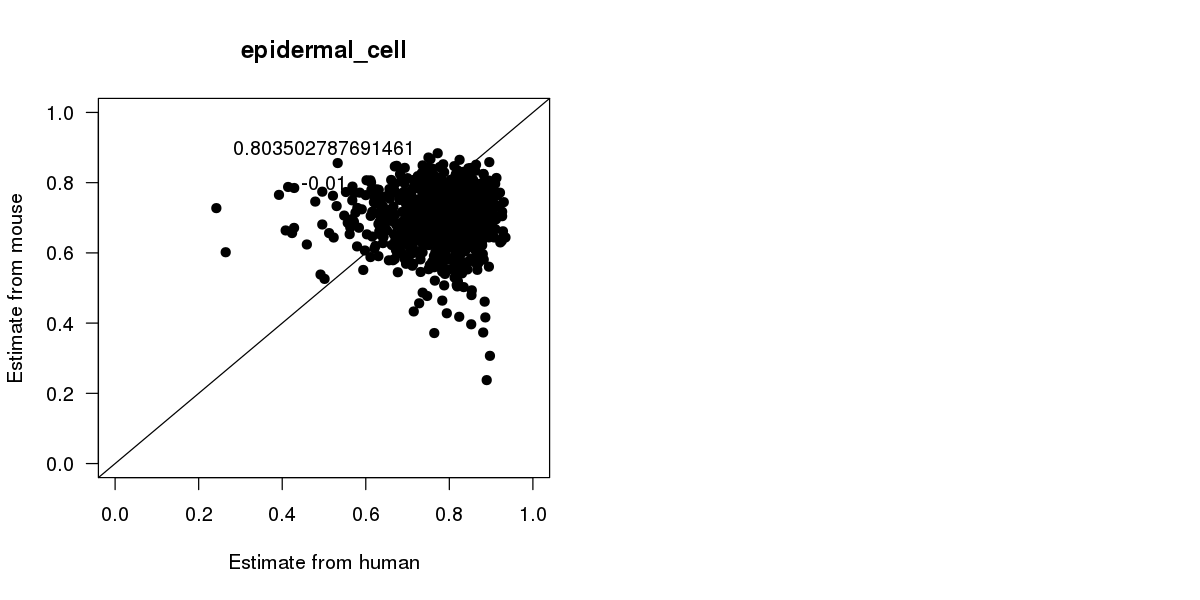

In [339]:
par(mfrow = c(1,2))
CorrPlotFrazer(human_estimates$Keratinocyte + human_estimates$Melanocyte,
               mouse_estimates$epidermal_cell + mouse_estimates$stem_cell_of_epidermis,
               1, "epidermal_cell")


cor.test(human_estimates$Keratinocyte + human_estimates$Melanocyte, mouse_estimates$basal_cell_of_epidermis, method = "pearson")


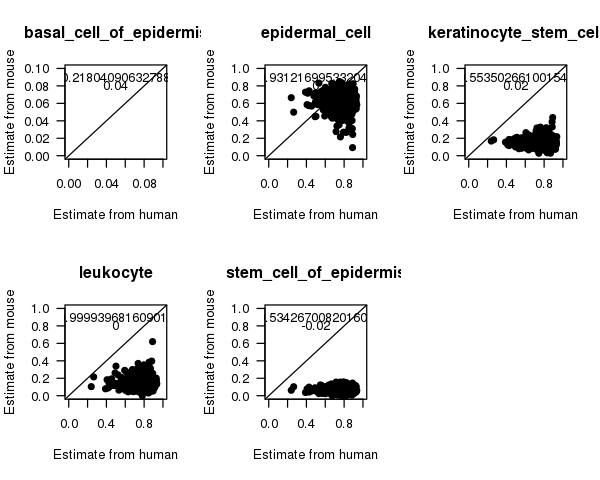

In [275]:
options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Keratinocyte , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Keratinocyte , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Keratinocyte , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Keratinocyte , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Keratinocyte , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”

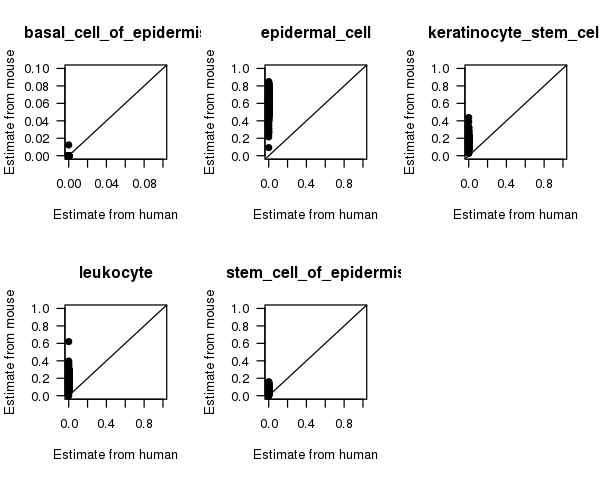

In [276]:
options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Lymphocyte , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Lymphocyte , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Lymphocyte , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Lymphocyte , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Lymphocyte , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

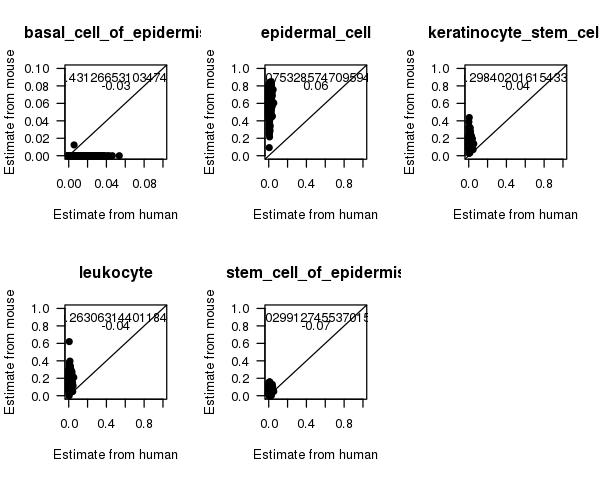

In [277]:
options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Macrophage.DC , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Macrophage.DC , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Macrophage.DC , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Macrophage.DC , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Macrophage.DC , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

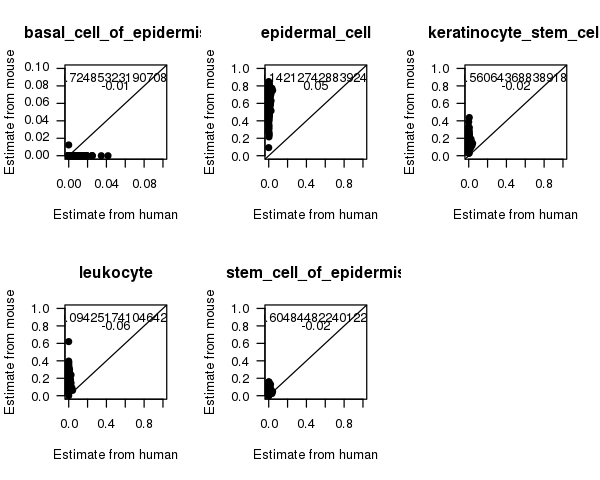

In [278]:
options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Melanocyte , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Melanocyte , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Melanocyte , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Melanocyte , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Melanocyte , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

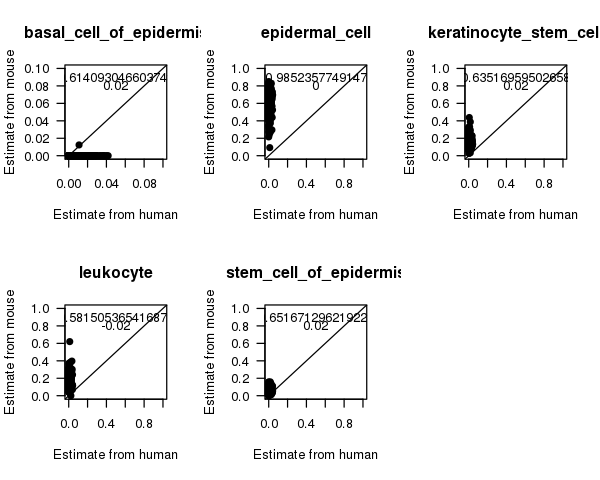

In [279]:
options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Neural_cell , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Neural_cell , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Neural_cell , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Neural_cell , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Neural_cell , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

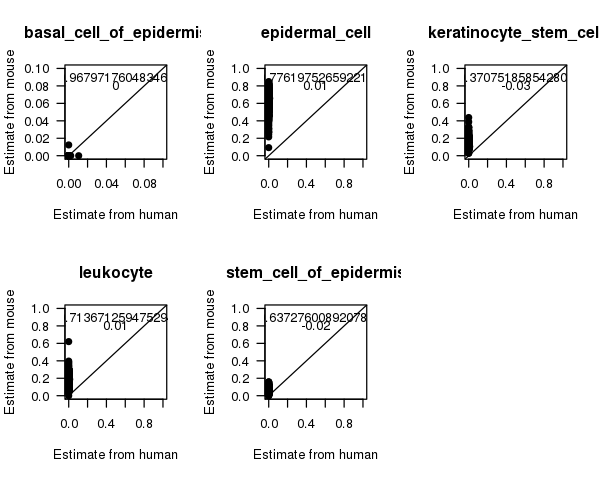

In [280]:
options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Pericyte , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Pericyte , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Pericyte , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Pericyte , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Pericyte , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

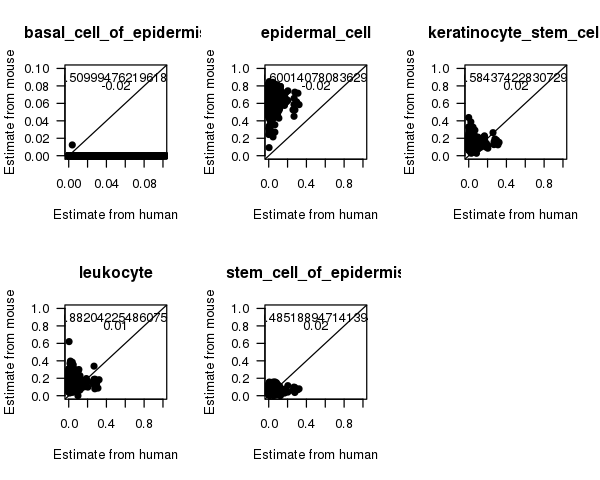

In [281]:
options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Secretory_epithelial , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Secretory_epithelial , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Secretory_epithelial , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Secretory_epithelial , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Secretory_epithelial , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

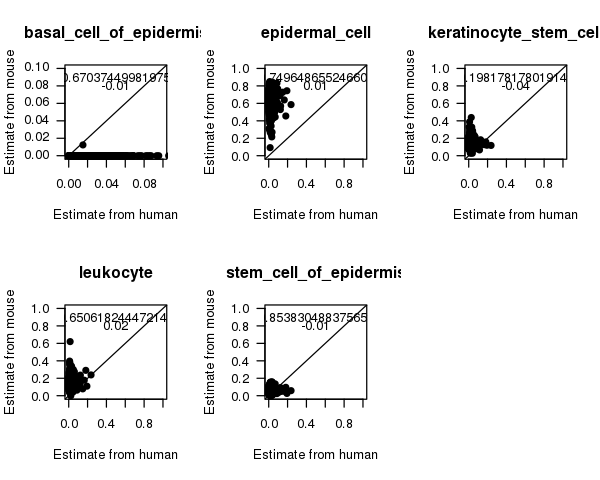

In [282]:
options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Smooth_muscle , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Smooth_muscle , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Smooth_muscle , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Smooth_muscle , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Smooth_muscle , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

# Correlation heatmap

In [234]:
library(corrplot)
library(stringr)
library(RColorBrewer)

corrplot 0.84 loaded


In [261]:
CorSpeciesFrazer <- function(human, mouse){
    
    rownames(human) <- human$Input.Sample
    human$Input.Sample <- NULL
    colnames(human) <- paste(colnames(human), "human", sep = "_")
    
    rownames(mouse) <- mouse$Input.Sample
    mouse$Input.Sample <- NULL
    colnames(mouse) <- paste(colnames(mouse), "mouse", sep = "_")
    
    m <- cbind(human, mouse)
    
    
    m$Lymphocyte_human <- NULL
#     m$ductal_human <- NULL
#     m$schwann_human <- NULL
    
    
    return(m)
}

In [301]:
HeatmapSpeciesFrazer <- function(human, mouse){
    
    m = CorSpeciesFrazer(human, mouse)
    res1 <- cor.mtest(m)
    m <- cor(m)

    rownames(res1$p) <- rownames(m)
    colnames(res1$p) <- colnames(m)

    m <- m[  grep("mouse", rownames(m)),]
    m <- m[, grep("human", colnames(m)) ]
    res1$p <- res1$p[  grep("mouse", rownames(res1$p)),]
    res1$p <- res1$p[, grep("human", colnames(res1$p)) ]
    
    rownames(m) = str_split_fixed(rownames(m), "_mouse", 2)[,1]
    colnames(m) = str_split_fixed(colnames(m), "_human", 2)[,1]

    
    rownames(m) = gsub("_", " ", rownames(m))
    colnames(m) = gsub("_", " ", colnames(m))
    
    
#     corrplot(m, method = "color", cl.ratio = 0.5, p.mat = res1$p, sig.level = c(10e-100, 10e-25, 10e-15), pch.cex = 2, insig = "label_sig", pch.col = "white")#,
    corrplot(m, method = "color", cl.ratio = 0.5, p.mat = res1$p, sig.level = c(10e-100, 10e-25, 10e-20), pch.cex = 2, insig = "label_sig", pch.col = "white")#,
#              col = rev(colorRampPalette(c("#67001F", "#B2182B", "#D6604D", "#F4A582",
#                               "#FDDBC7", "#FFFFFF", "#D1E5F0", "#92C5DE",
#                               "#4393C3", "#2166AC", "#053061"))(200)))
    
    return(m)
    
}

Keratinocyte  Endothelial cell Fibroblast   Melanocyte 
basal cell of epidermis  4.204505e-02 -3.696483e-02    -0.036560900 -0.01201947
epidermal cell          -2.947556e-03  2.055739e-02    -0.008227184  0.05009690
keratinocyte stem cell   2.023211e-02 -1.539610e-02    -0.009927324 -0.01986908
leukocyte               -2.581622e-06 -2.148292e-02     0.011602867 -0.05709841
stem cell of epidermis  -2.122164e-02 -6.058513e-05     0.018689232 -0.01766909
                        Pericyte     Macrophage.DC Smooth muscle Cornified.Env
basal cell of epidermis -0.001371173 -0.02687161   -0.01453437    0.027362103 
epidermal cell           0.009707682  0.06067730    0.01089684    0.004440987 
keratinocyte stem cell  -0.030558812 -0.03549960   -0.04392084   -0.015991206 
leukocyte                0.012529941 -0.03820537    0.01546545   -0.001877760 
stem cell of epidermis  -0.016100761 -0.07404484   -0.00629139    0.012587631 
                        Secretory epithelial Neural cell   B cell      
basal cell of epidermis -0.022496334          0.0172181947 -0.001576356
epidermal cell          -0.017899608          0.0006319435  0.058147297
keratinocyte stem cell   0.018678308          0.0162015654 -0.060969429
leukocyte                0.005067081         -0.0188210366 -0.053091615
stem cell of epidermis   0.023832244          0.0154155379  0.007501279

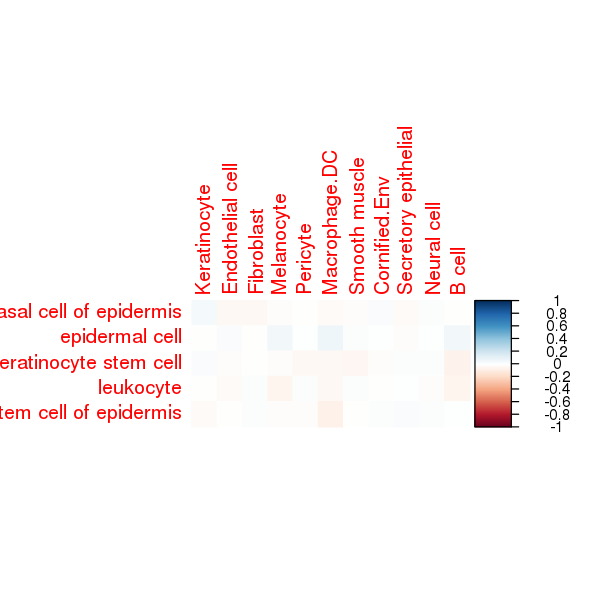

In [302]:
HeatmapSpeciesFrazer(human_estimates[, !colnames(human_estimates) %in% c("P.value", "Pearson.Correlation", "RMSE")],
                     mouse_estimates[, !colnames(mouse_estimates) %in% c("P.value", "Pearson.Correlation", "RMSE")])

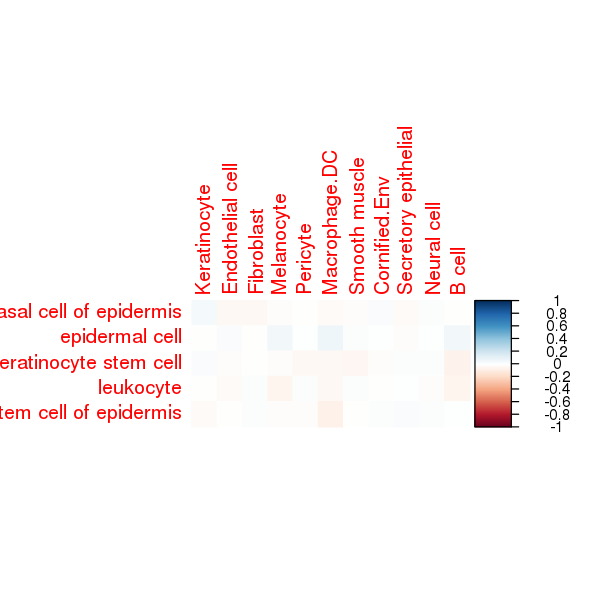

In [285]:
figure_width  =  5
figure_height = 5
options(repr.plot.width = figure_width, repr.plot.height = figure_height)

HeatmapSpeciesFrazer(human_estimates[, !colnames(human_estimates) %in% c("P.value", "Pearson.Correlation", "RMSE")],
                     mouse_estimates[, !colnames(mouse_estimates) %in% c("P.value", "Pearson.Correlation", "RMSE")])

# Try integrating, because I don't know what anything is.

In [341]:
mouse_skin
human_skin

An object of class Seurat 
16180 features across 2263 samples within 1 assay 
Active assay: RNA (16180 features)
 3 dimensional reductions calculated: pca, tsne, umap

An object of class Seurat 
32738 features across 8366 samples within 1 assay 
Active assay: RNA (32738 features)
 2 dimensional reductions calculated: pca, umap

## modify mouse gene names

In [377]:
mouse_skin_newgenes = mouse_skin

In [372]:
newGenes = toupper(rownames(GetAssayData(object = mouse_skin_newgenes)))

In [382]:
data = GetAssayData(object = mouse_skin_newgenes)
rownames(data) <- newGenes
meta = mouse_skin_newgenes@meta.data

In [384]:
mouse_skin_newgenes <- CreateSeuratObject(data, meta.data = meta)

In [388]:
mouse_skin_newgenes = FindVariableFeatures(mouse_skin_newgenes, selection.method = "vst", nfeatures = 2000, verbose = FALSE)
mouse_skin_newgenes <- ScaleData(mouse_skin_newgenes)
mouse_skin_newgenes <- RunPCA(mouse_skin_newgenes, npcs = 30, verbose = FALSE)
mouse_skin_newgenes <- RunUMAP(object = mouse_skin_newgenes, reduction.use = "pca", dims = 1:12, min_dist = .4, seed = 10) #PCs used based on PCElbowPlot(object = mouse_liver)

Centering and scaling data matrix


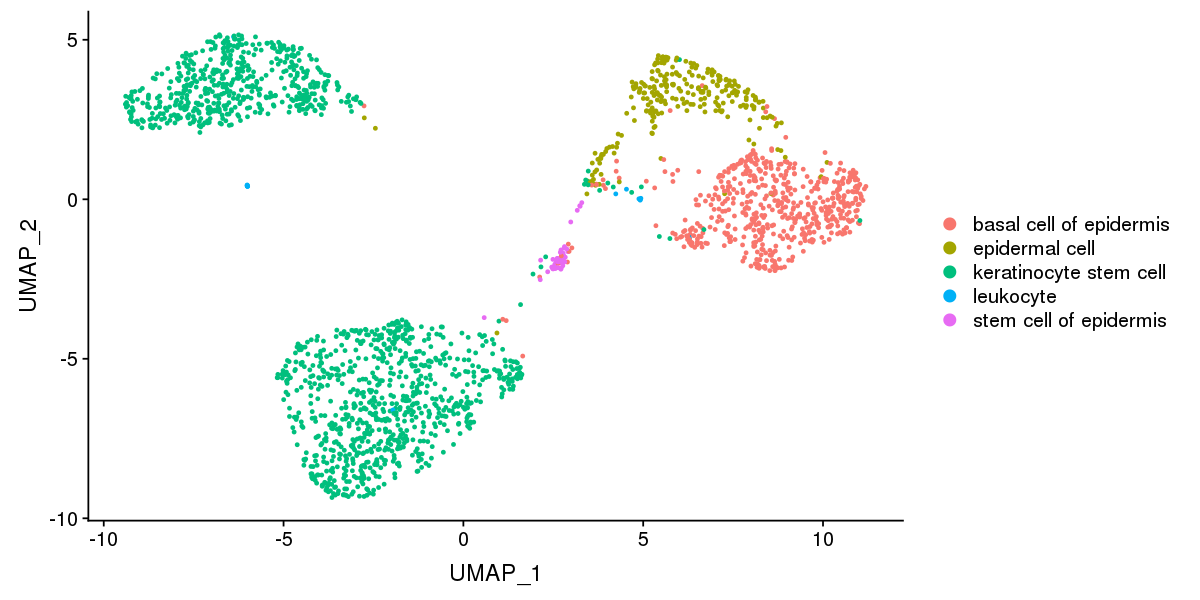

In [390]:
DimPlot(mouse_skin_newgenes, group.by = "cell_ontology_class")

## integrate

In [391]:
reference.list = list()
reference.list[["human_skin"]] <- human_skin
reference.list[["mouse_skin"]] <- mouse_skin_newgenes

In [392]:
anchors <- FindIntegrationAnchors(object.list = reference.list, dims = 1:10)

Computing 2000 integration features
Scaling features for provided objects
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 6927 anchors
Filtering anchors
	Retained 2955 anchors
Extracting within-dataset neighbors


In [420]:
integrated <- IntegrateData(anchorset = anchors, dims = 1:10)

Merging dataset 2 into 1
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
Integrating data


In [466]:
DefaultAssay(integrated) <- "integrated"

# Run the standard workflow for visualization and clustering
integrated <- ScaleData(integrated, verbose = FALSE)
integrated <- RunPCA(integrated, npcs = 30, verbose = FALSE)
# UMAP and Clustering
integrated <- RunUMAP(integrated, reduction = "pca", dims = 1:15, min_dist = .05)

In [498]:
integrated.reannotate = integrated

In [499]:
integrated@meta.data$cell_ontology_class.temp = integrated@meta.data$cell_ontology_class

In [500]:
integrated@meta.data[integrated@meta.data$cell_ontology_class == "Keratinocyte", "cell_ontology_class"] = paste(integrated@meta.data[integrated@meta.data$cell_ontology_class == "Keratinocyte", "cell_ontology_class"], 
                                                                                           integrated@meta.data[integrated@meta.data$cell_ontology_class == "Keratinocyte", "res.0.6"],
                                                                                           sep = "_")

In [501]:
integrated@meta.data[integrated@meta.data$cell_ontology_class == "Fibroblast", "cell_ontology_class"] = paste(integrated@meta.data[integrated@meta.data$cell_ontology_class == "Fibroblast", "cell_ontology_class"], 
                                                                                           integrated@meta.data[integrated@meta.data$cell_ontology_class == "Fibroblast", "res.0.6"],
                                                                                           sep = "_")

In [502]:
integrated@meta.data[integrated@meta.data$cell_ontology_class == "Pericyte", "cell_ontology_class"] = paste(integrated@meta.data[integrated@meta.data$cell_ontology_class == "Pericyte", "cell_ontology_class"], 
                                                                                           integrated@meta.data[integrated@meta.data$cell_ontology_class == "Pericyte", "res.0.6"],
                                                                                           sep = "_")

In [503]:
integrated@meta.data$free_annotation <- integrated@meta.data$annotation 

In [504]:
integrated@meta.data[is.na(integrated@meta.data$free_annotation), "free_annotation"] = integrated@meta.data[is.na(integrated@meta.data$free_annotation), "cell_ontology_class"]

In [505]:
integrated@meta.data$species = integrated@meta.data$orig.ident

integrated@meta.data[! (integrated@meta.data$species == "Skin"), "species"] = "Human"
integrated@meta.data[ (integrated@meta.data$species == "Skin"), "species"] = "Mouse"

In [506]:
integrated@meta.data$cell_species = paste(integrated@meta.data$species, integrated@meta.data$cell_ontology_class, sep = "_")

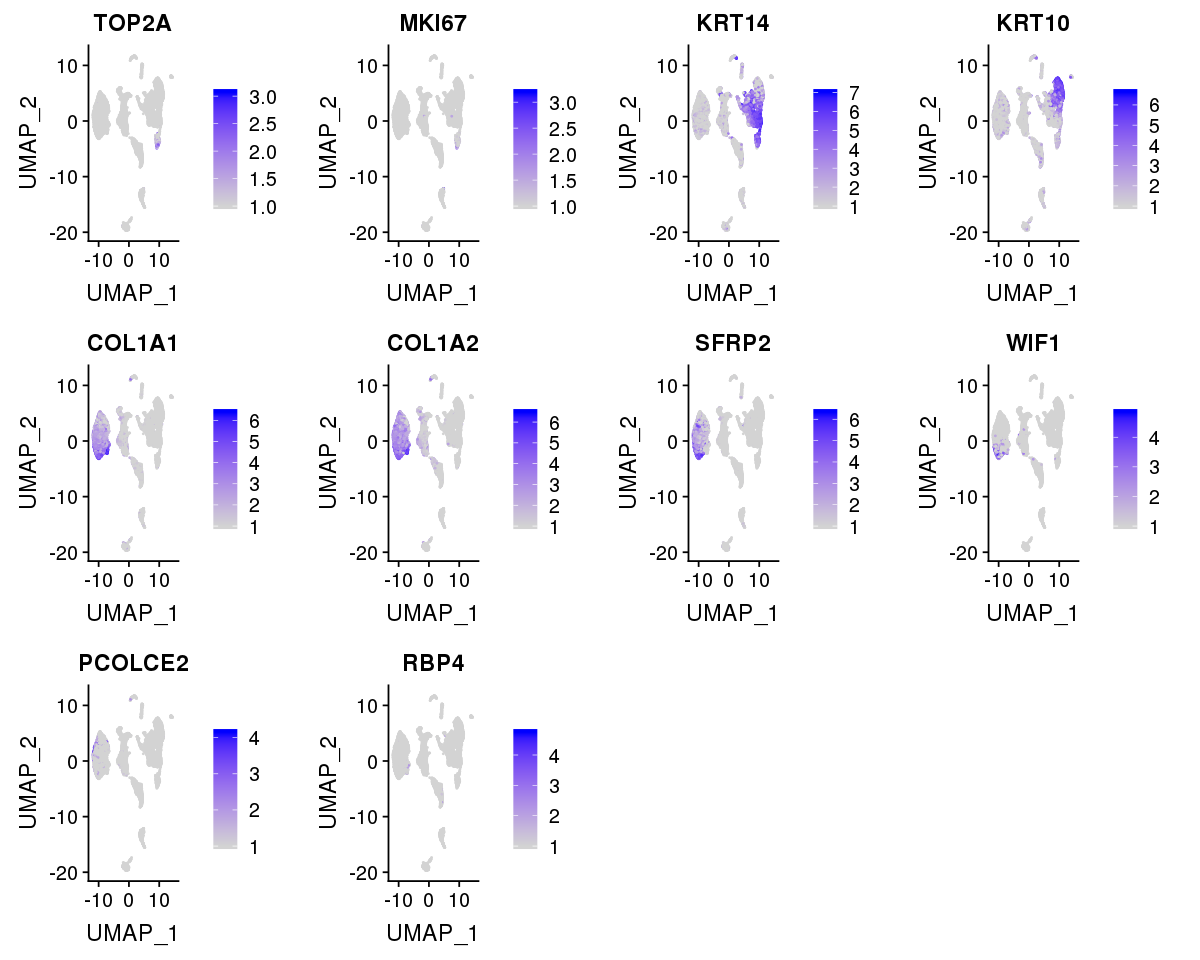

In [496]:
options(repr.plot.width = 10, repr.plot.height = 8)
FeaturePlot(integrated, features = c("TOP2A", "MKI67", "KRT14", "KRT10", "COL1A1", "COL1A2", "SFRP2", "WIF1", "PCOLCE2", "RBP4"), min.cutoff = 1, ncol = 4)

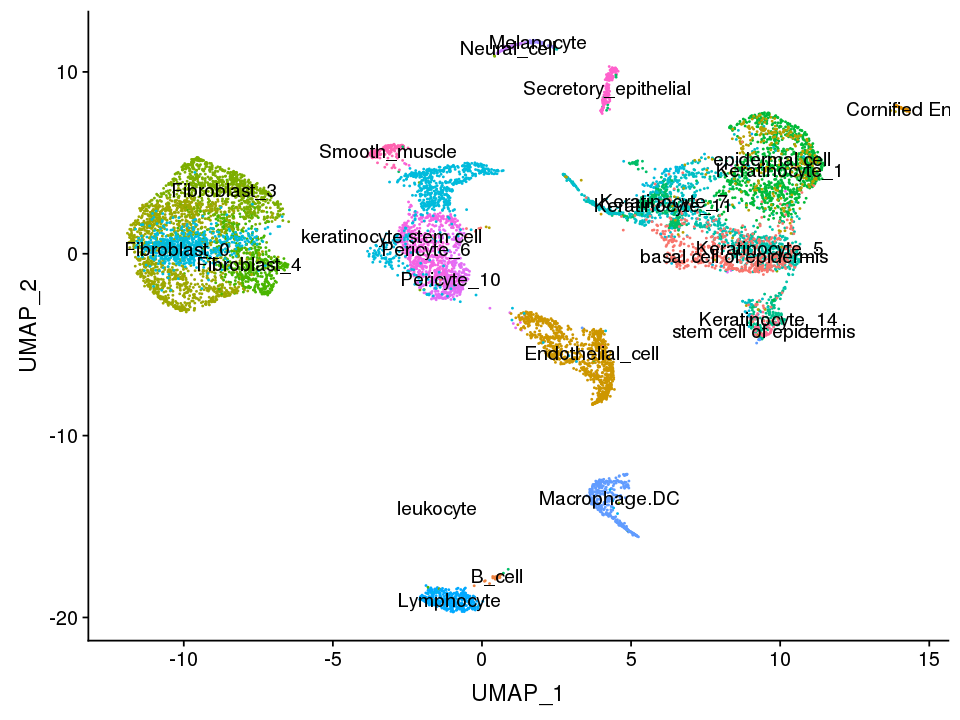

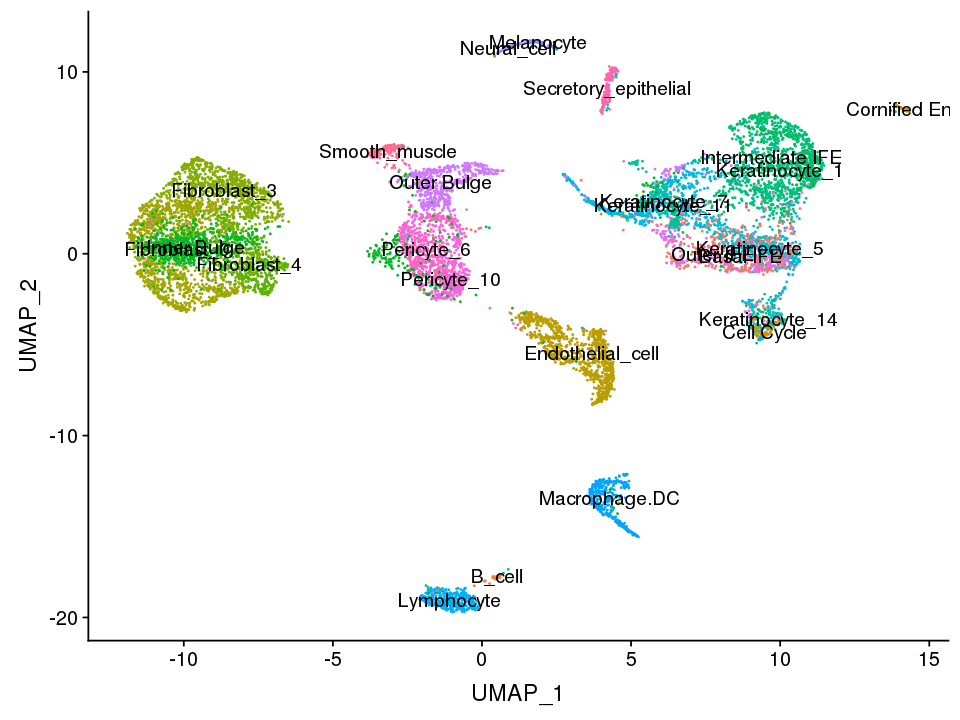

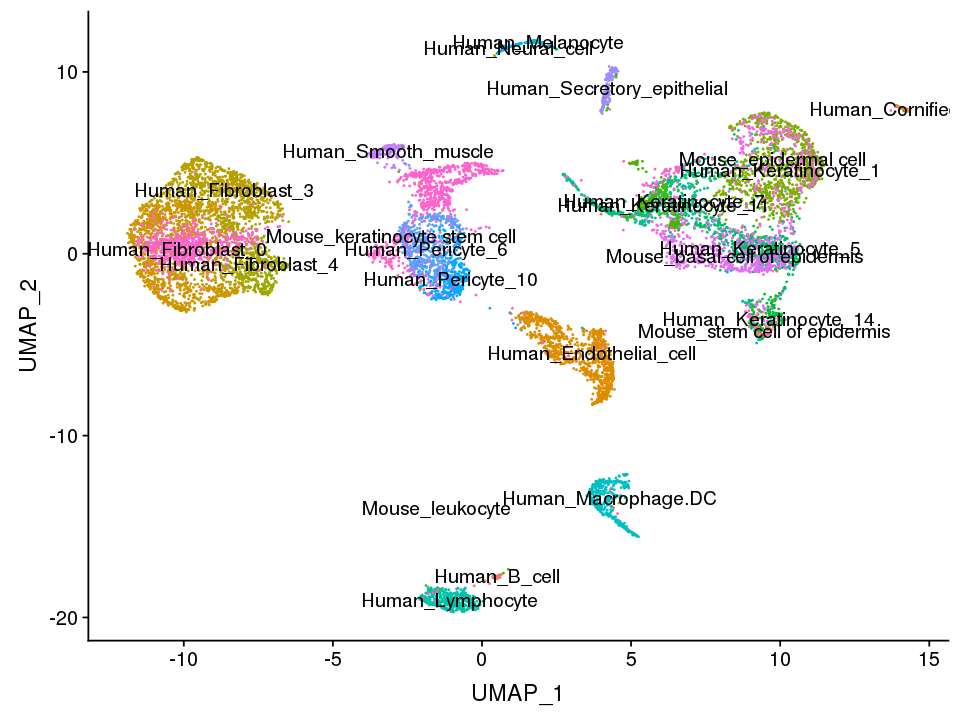

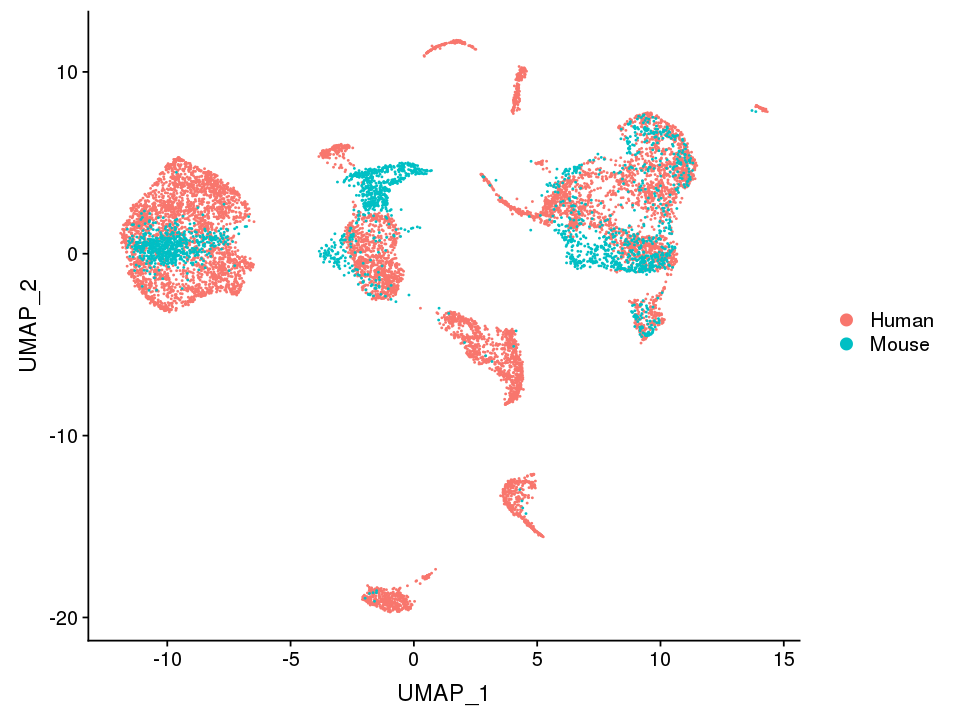

In [626]:
options(repr.plot.width = 8, repr.plot.height = 6)
DimPlot(integrated, group.by = "cell_ontology_class", label = T) + NoLegend()
DimPlot(integrated, group.by = "free_annotation", label = T) + NoLegend()
DimPlot(integrated, group.by = "cell_species", label = T) + NoLegend()

DimPlot(integrated, group.by = "species", label = F)


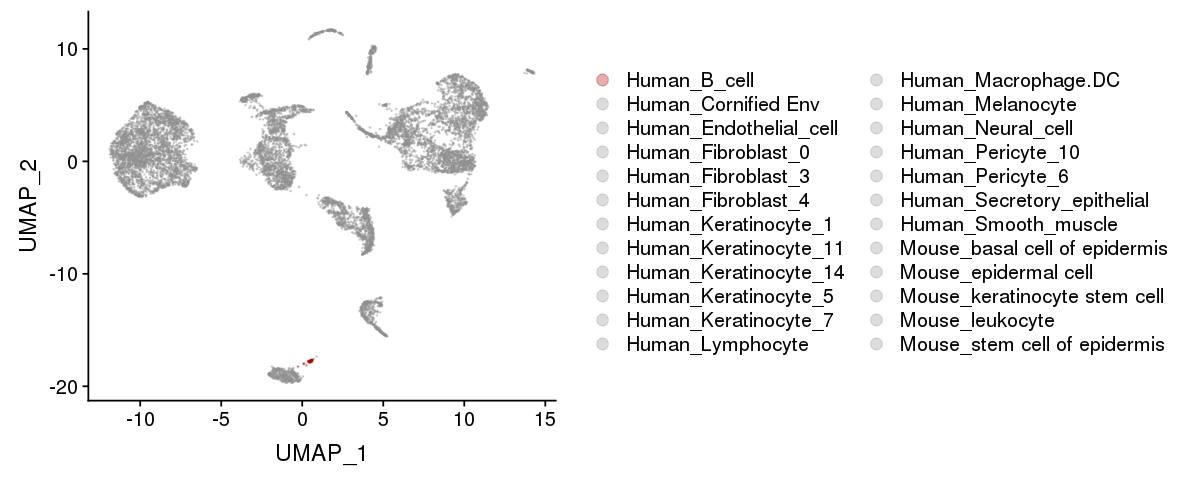

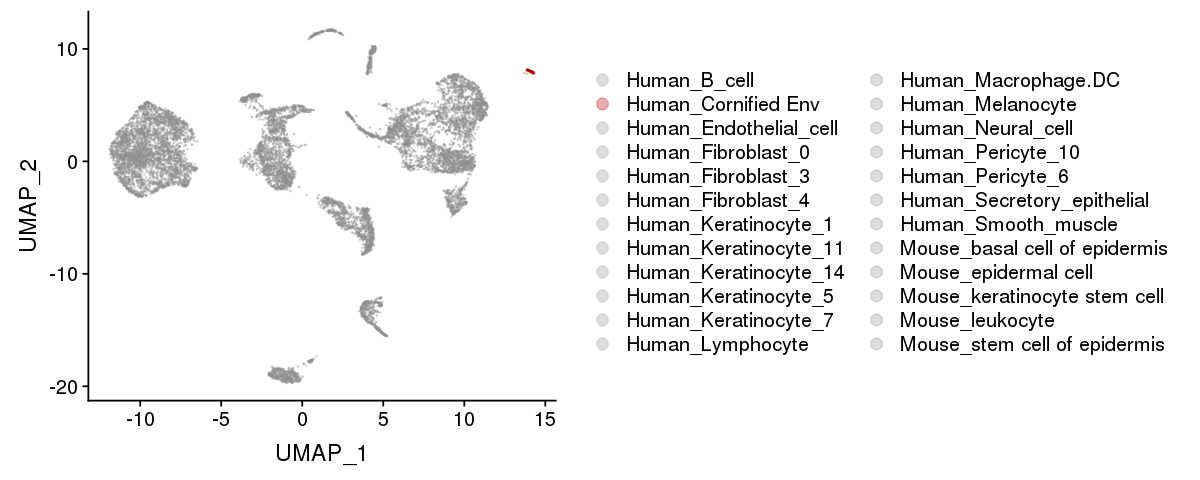

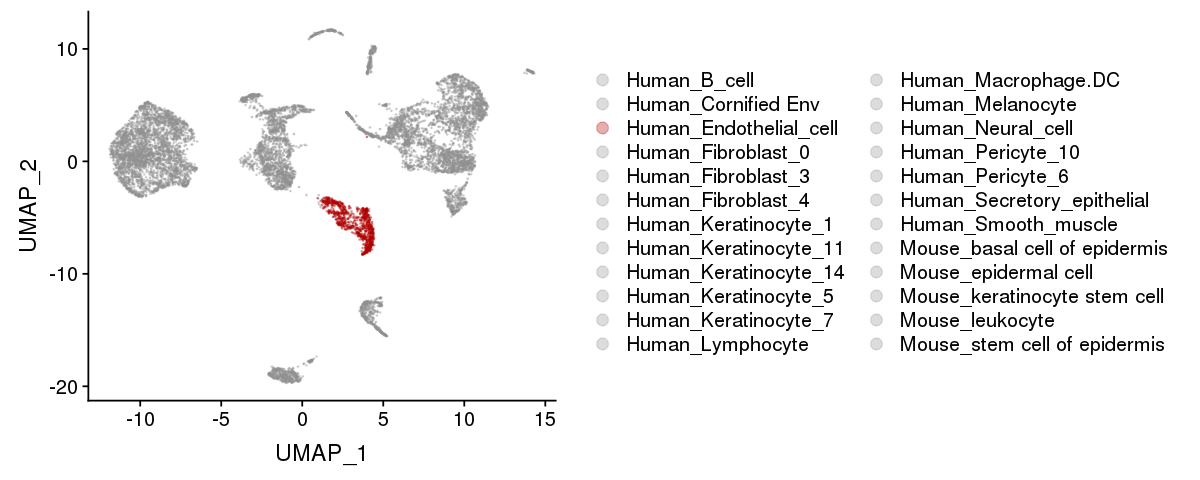

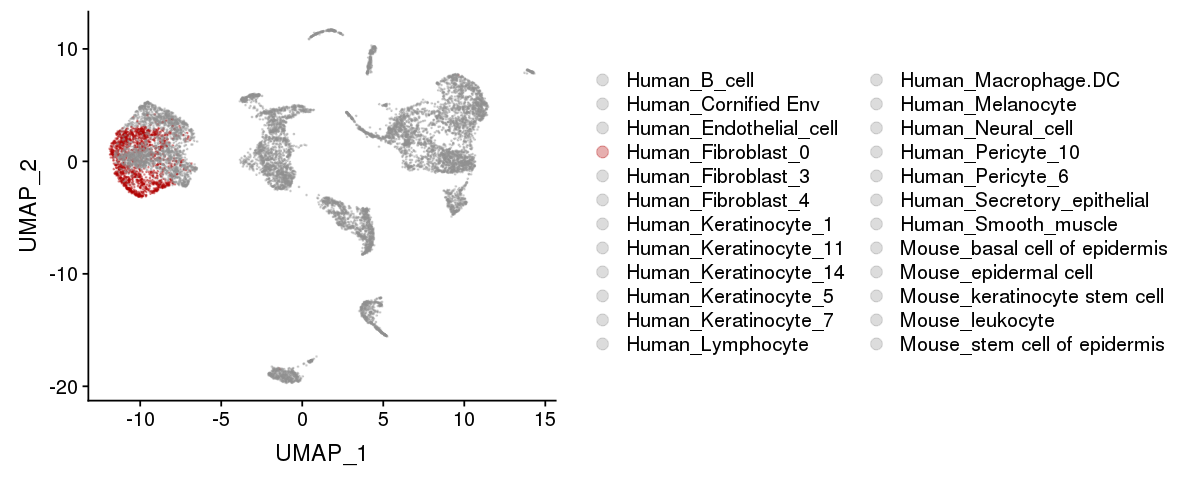

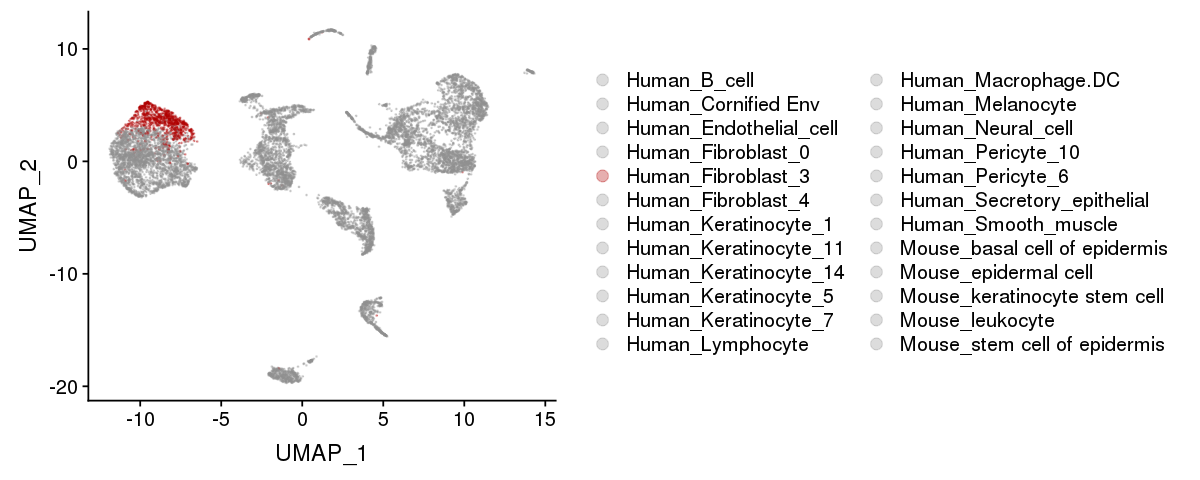

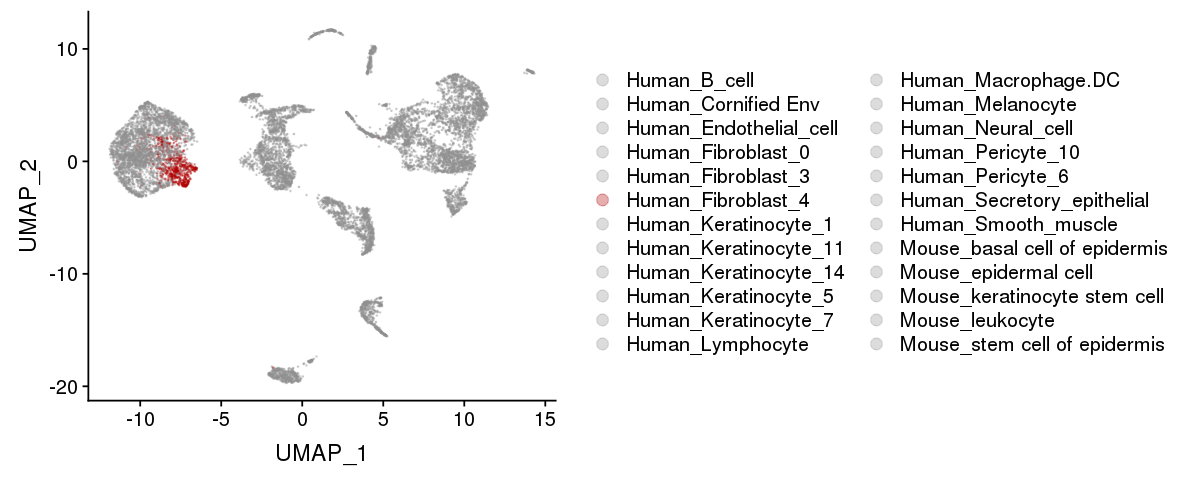

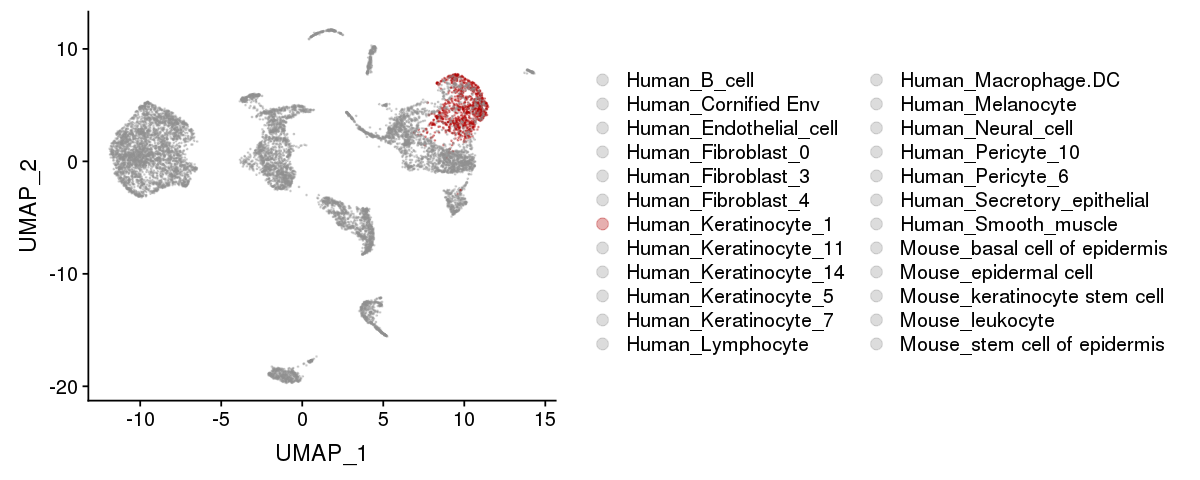

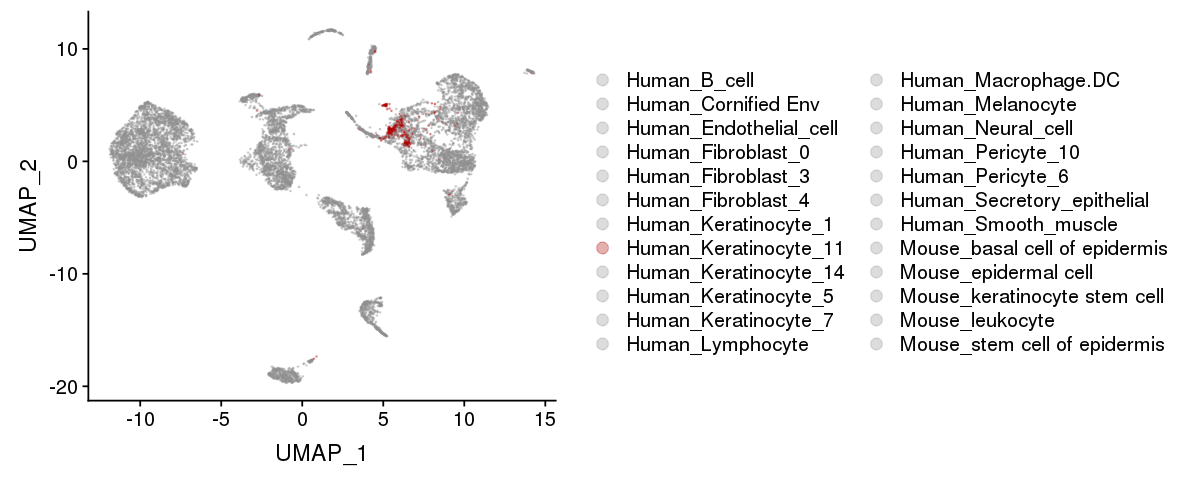

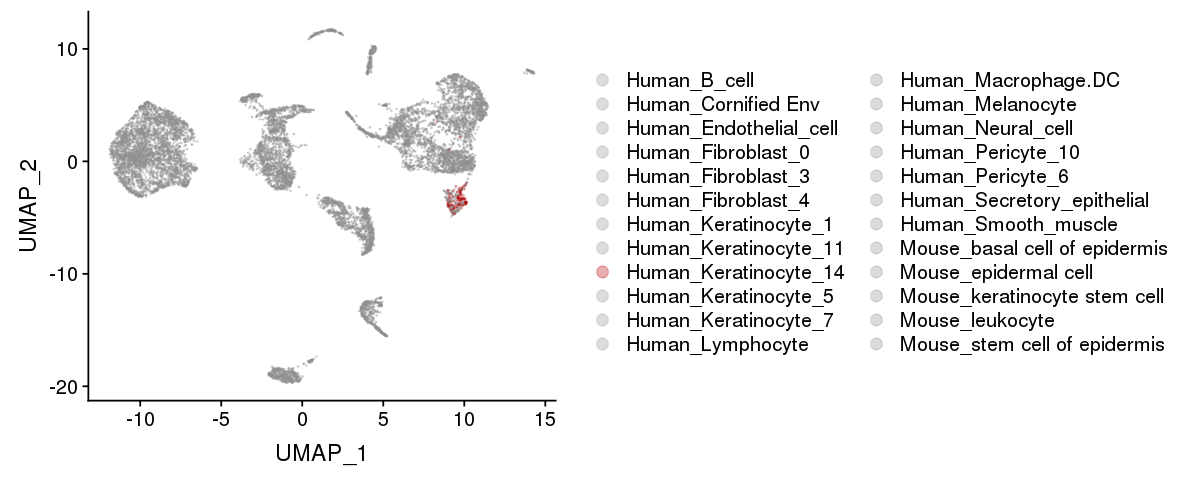

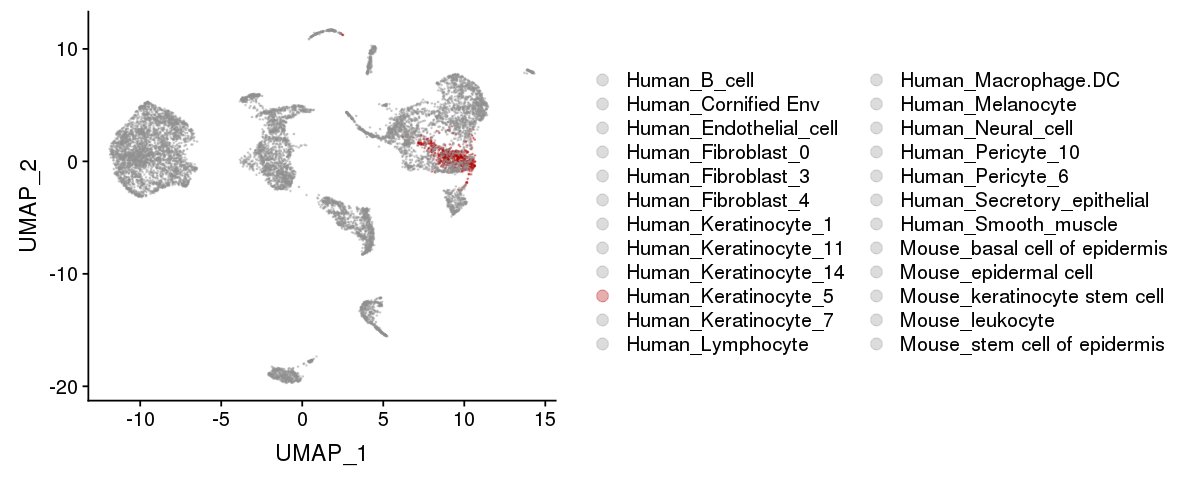

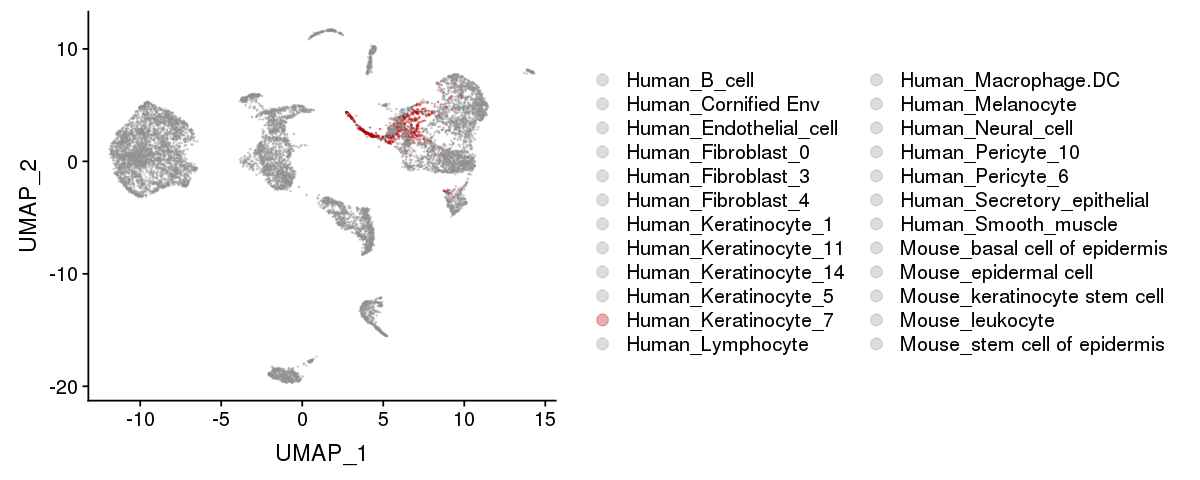

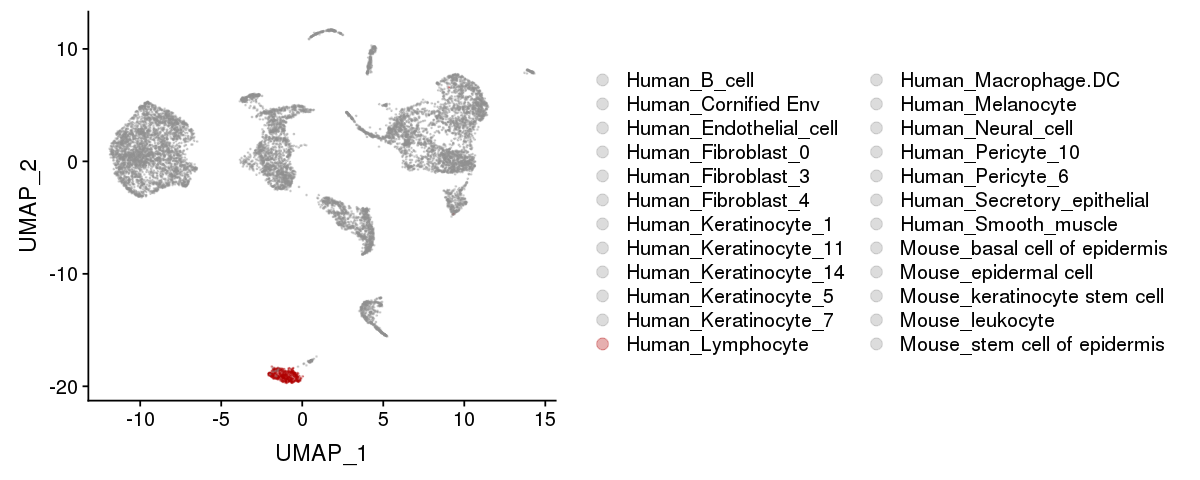

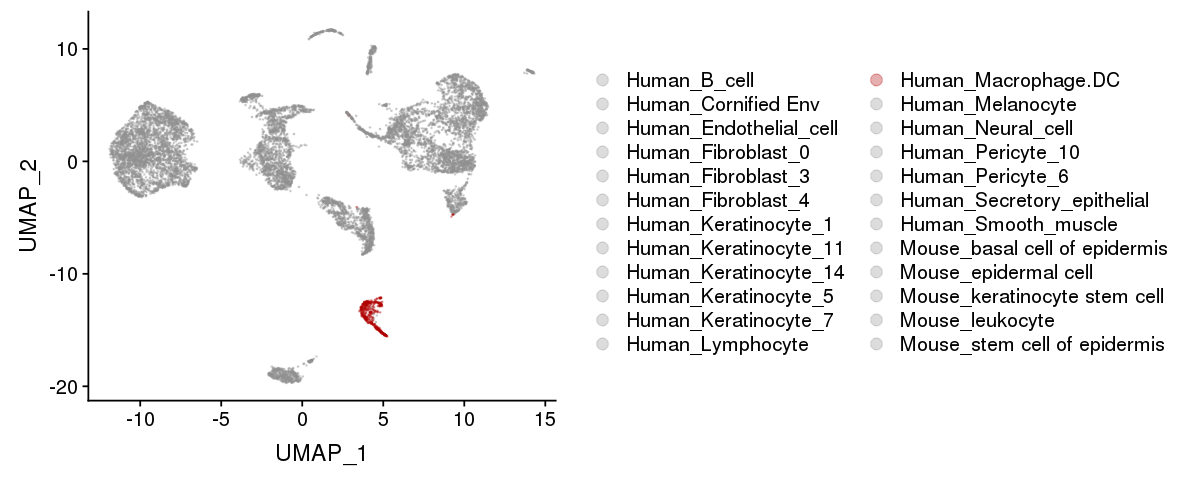

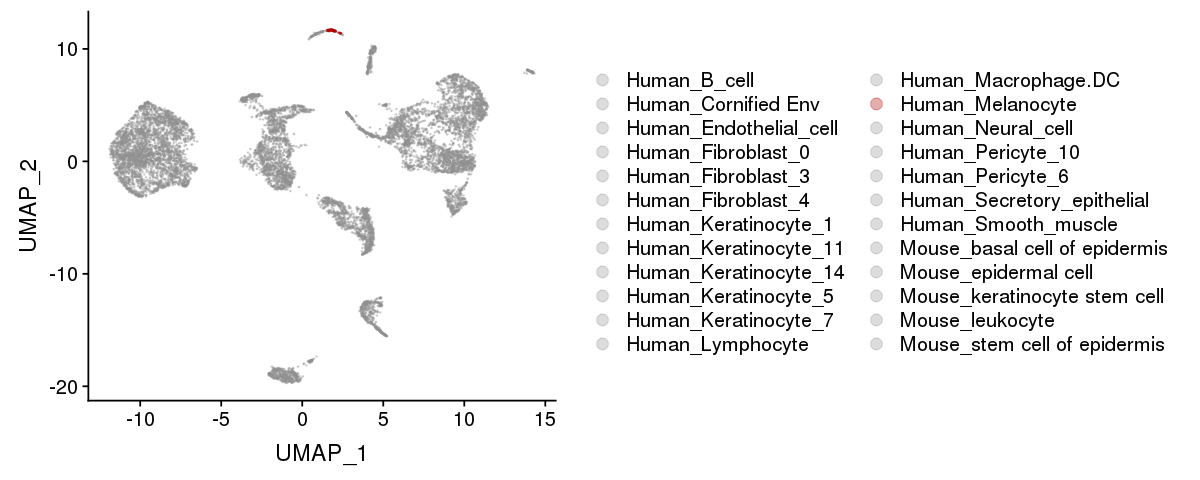

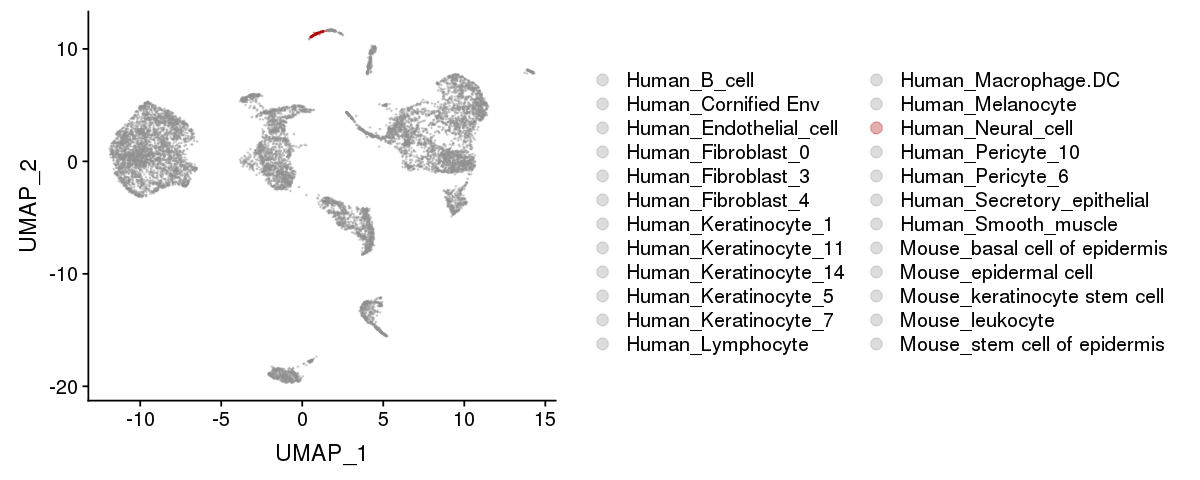

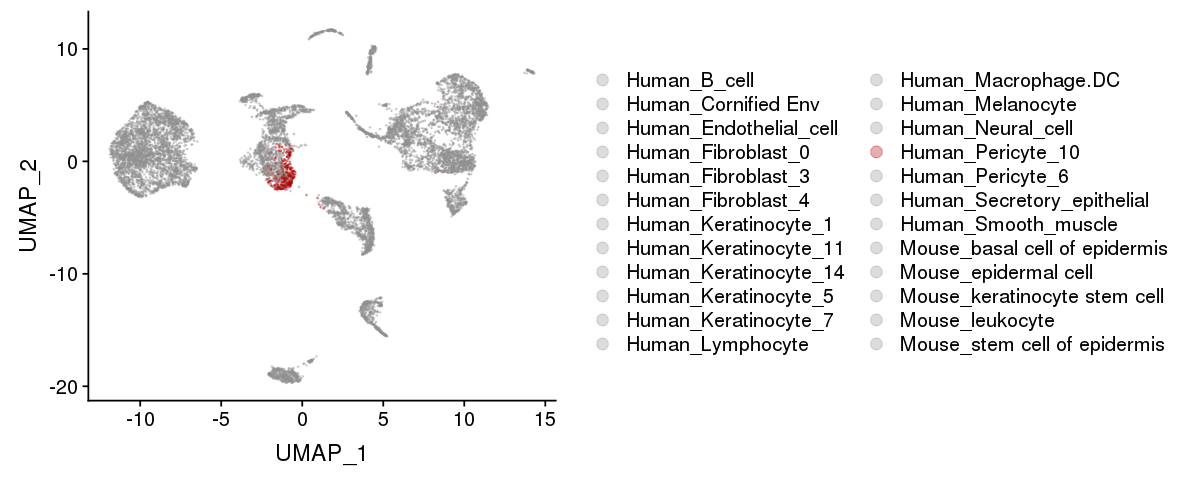

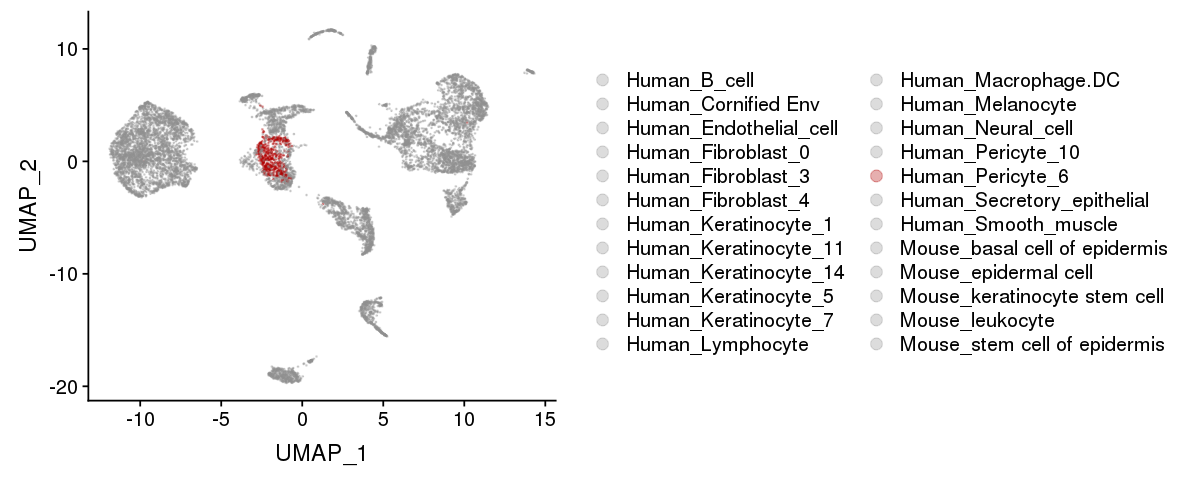

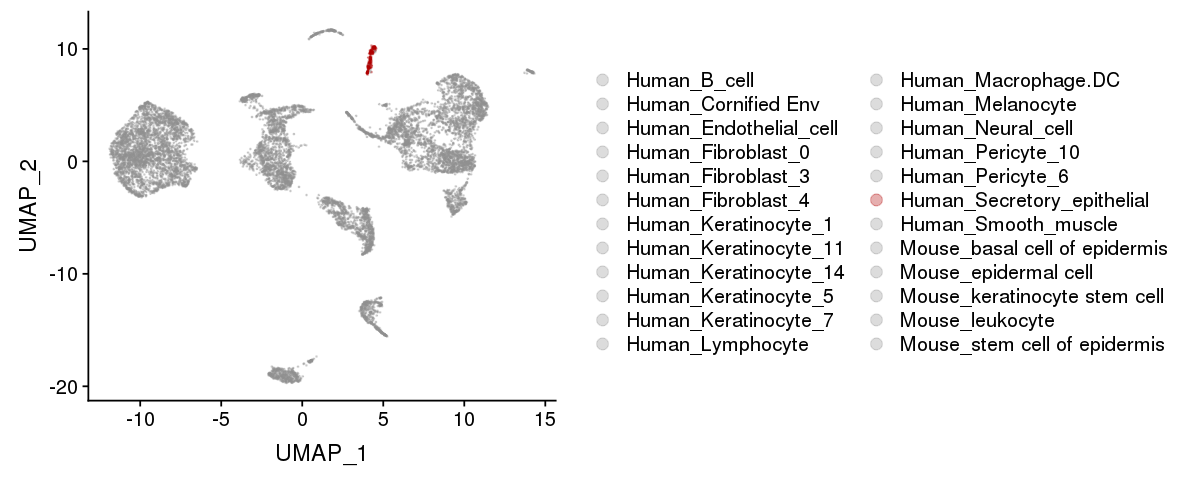

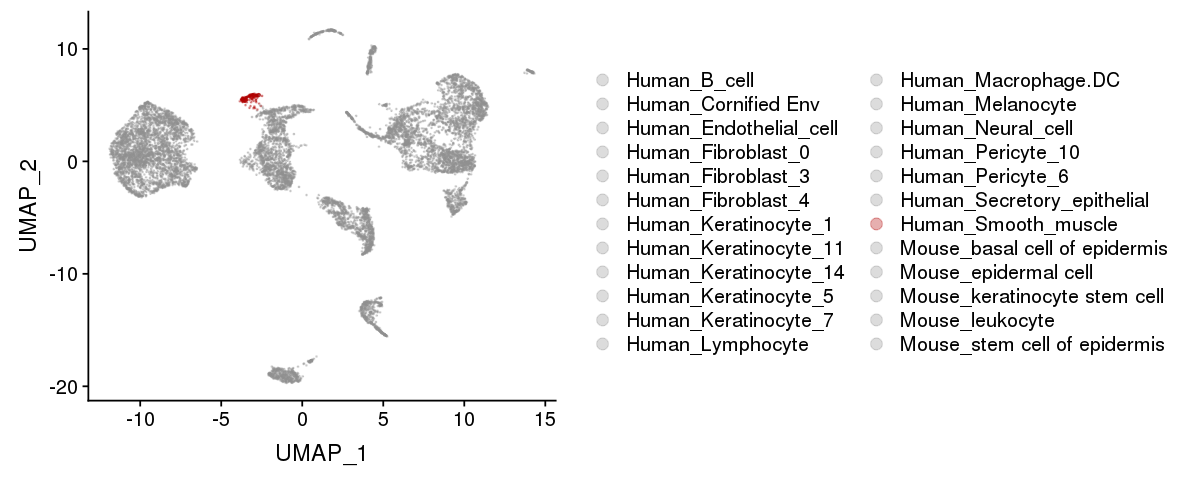

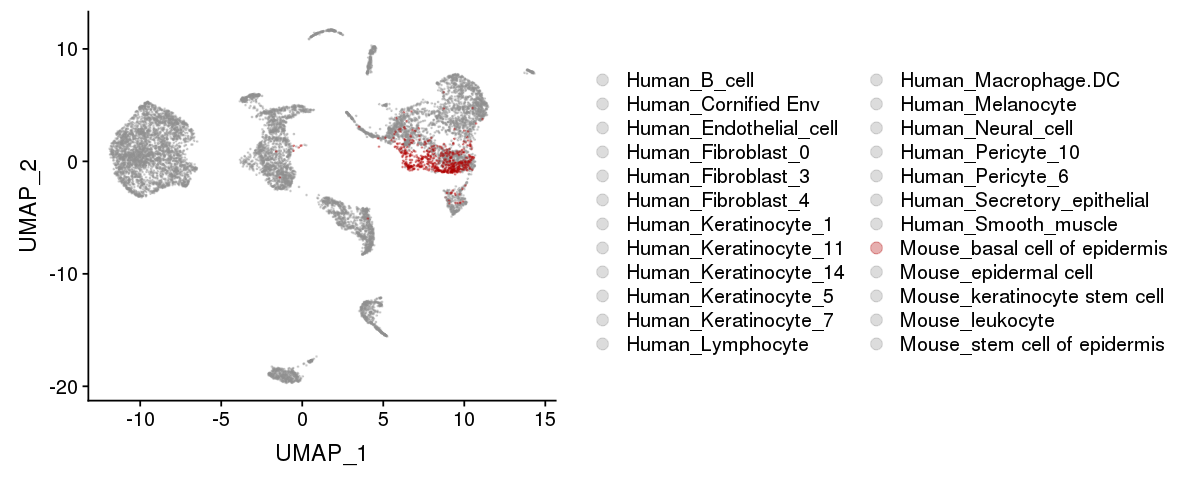

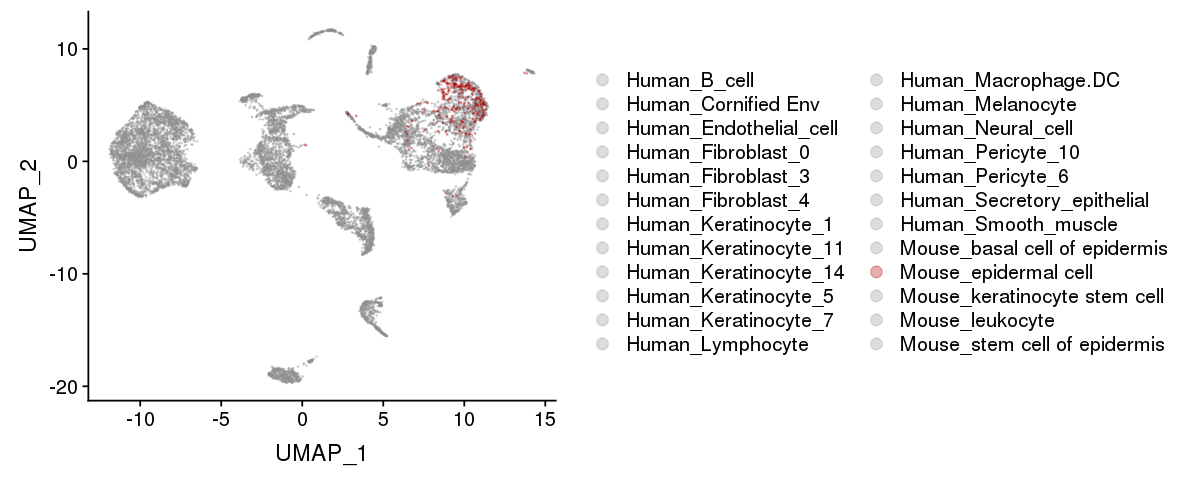

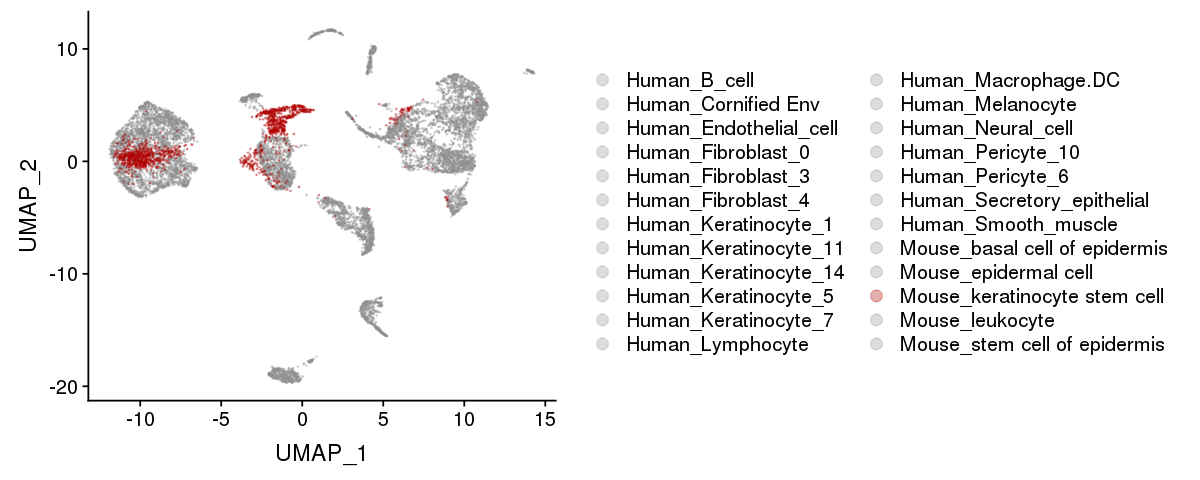

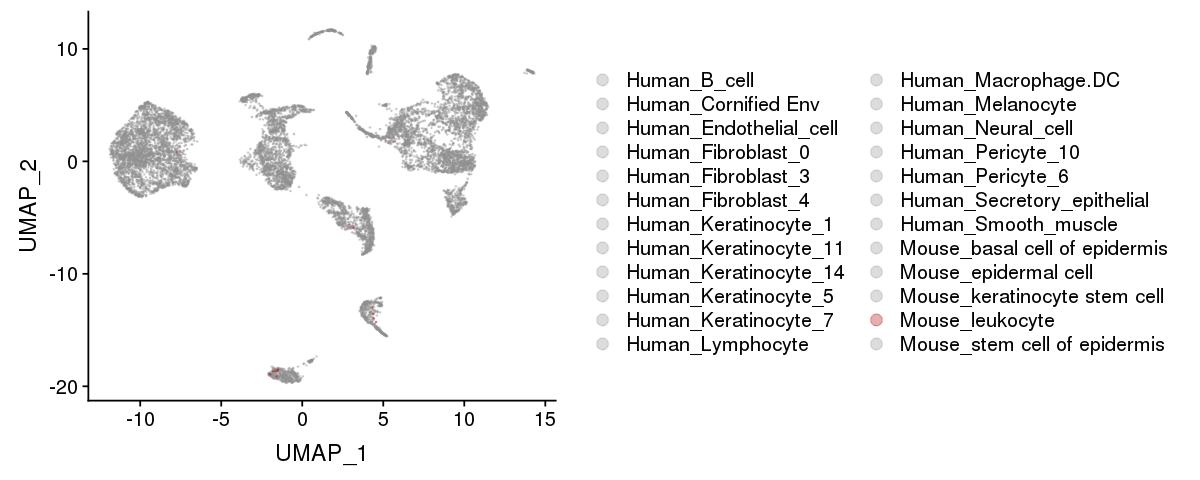

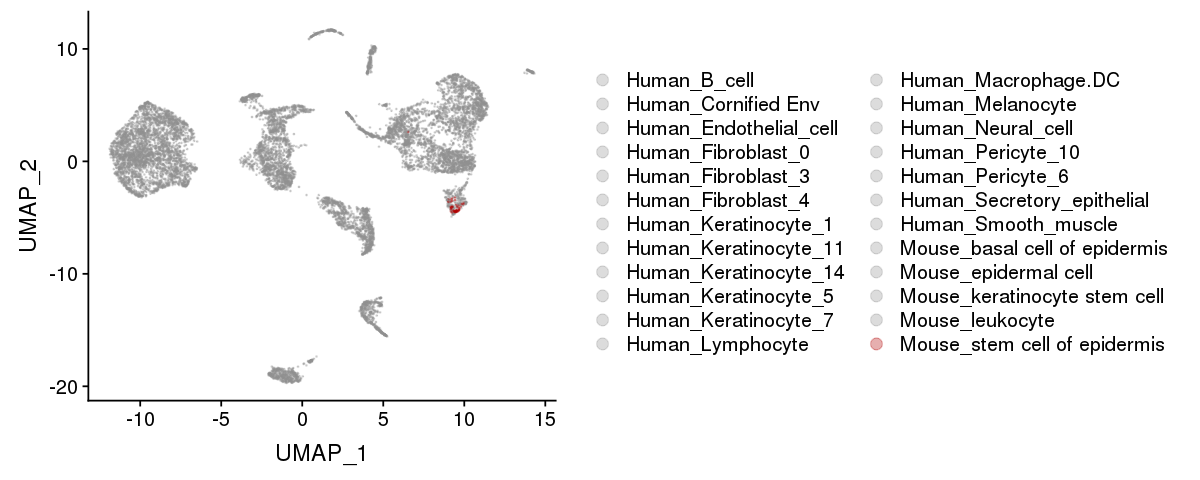

In [611]:
options(repr.plot.width = 10, repr.plot.height = 4)
for( i in seq(1, 24)){
    
    c = rep("#91919150", 24)
    c[i] = "#b0000050"
    
    print(DimPlot(integrated, group.by = "cell_species", label = F, cols = c))
    
}

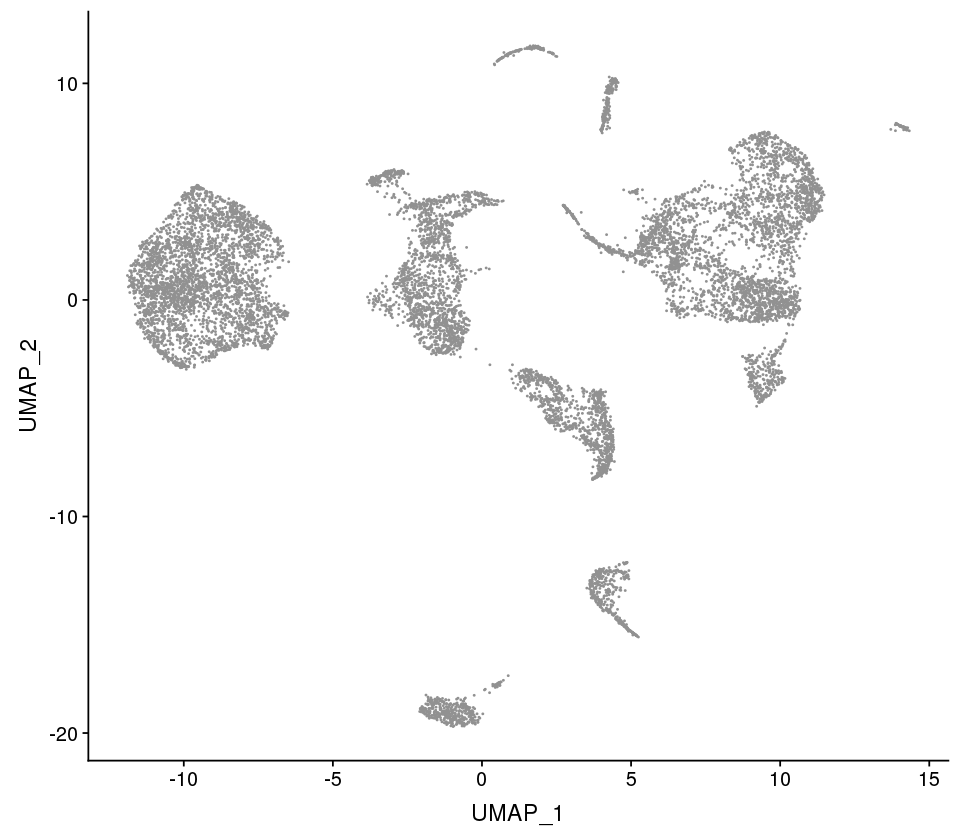

In [625]:
DimPlot(integrated, group.by = "cell_species", label = F, cols = rep("#919191", 24)) + NoLegend()

In [598]:
# options(repr.plot.width = 12, repr.plot.height = 14)
# integrated.identnew = integrated
# Idents(object = integrated.identnew) <- integrated.identnew@meta.data$cell_species
# DimPlot(integrated.identnew, group.by = "species", label = F, split.by = 'ident', ncol = 4) + NoLegend()


# Extract signature genes from cells in epidermis of human scRNA-seq

In [533]:
human_skin

An object of class Seurat 
32738 features across 8366 samples within 1 assay 
Active assay: RNA (32738 features)
 2 dimensional reductions calculated: pca, umap

In [537]:
human_skin_epidermis <- human_skin

In [538]:
human_skin_epidermis@meta.data$celltype_cluster = paste(human_skin_epidermis@meta.data$celltype, human_skin_epidermis@meta.data$res.0.6, sep = "_")

In [542]:
Idents(object = human_skin_epidermis) <- human_skin_epidermis@meta.data$res.0.6

In [544]:
human_skin_epidermis = subset(human_skin_epidermis, idents = c(0, 1, 3, 4, 5, 7, 9, 11, 14, 17))

In [545]:
human_skin_epidermis

An object of class Seurat 
32738 features across 5670 samples within 1 assay 
Active assay: RNA (32738 features)
 2 dimensional reductions calculated: pca, umap

In [785]:
## recluster
# human_skin_epidermis <- FindVariableFeatures(human_skin_epidermis)
# human_skin_epidermis <- ScaleData(human_skin_epidermis)
# human_skin_epidermis <- RunPCA(human_skin_epidermis)
# human_skin_epidermis <- FindNeighbors(human_skin_epidermis, dims = 1:10)
# human_skin_epidermis <- FindClusters(human_skin_epidermis, resolution = 0.5)
# human_skin_epidermis <- RunUMAP(human_skin_epidermis, dims = 1:10)

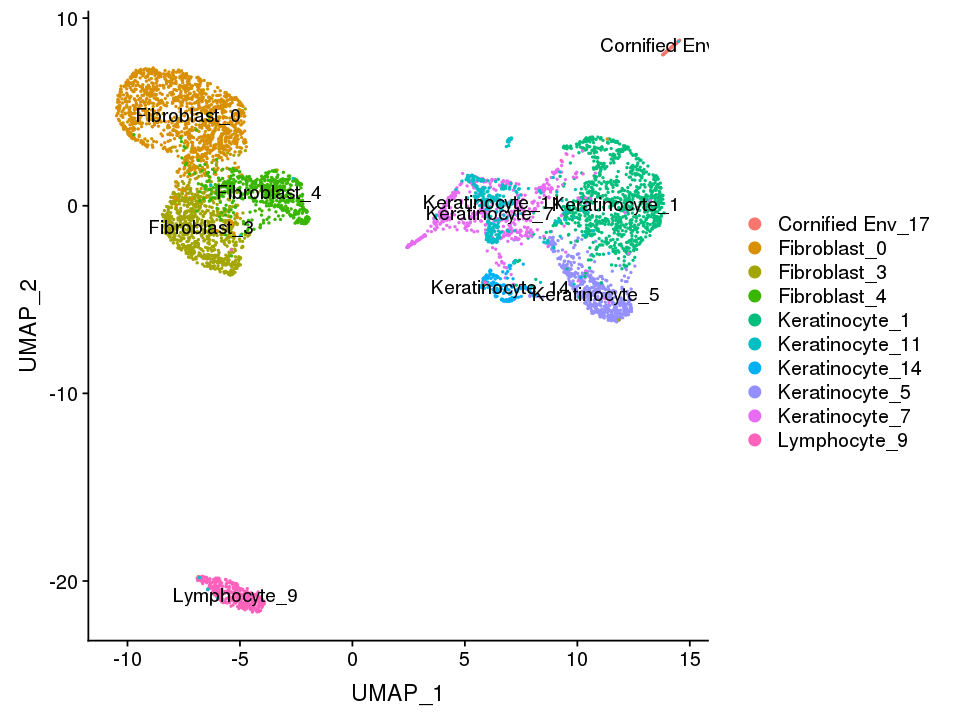

In [787]:
options(repr.plot.width = 8, repr.plot.height = 6)
DimPlot(human_skin_epidermis, reduction = "umap", group.by = "celltype_cluster", label = T)

In [788]:
# reannoate
human_skin_epidermis@meta.data$new_cellnames = human_skin_epidermis@meta.data$celltype_cluster
human_skin_epidermis@meta.data[human_skin_epidermis@meta.data$new_cellnames %in% c("Keratinocyte_11", "Keratinocyte_7"), "new_cellnames"] = "Keratinocyte_7_11"

In [789]:
table(human_skin_epidermis@meta.data$new_cellnames)


 Cornified Env_17      Fibroblast_0      Fibroblast_3      Fibroblast_4 
               43              1309               871               562 
   Keratinocyte_1   Keratinocyte_14    Keratinocyte_5 Keratinocyte_7_11 
              954               154               552               849 
     Lymphocyte_9 
              376 

In [790]:
Idents(object = human_skin_epidermis) <- "new_cellnames"

cts = unique(Idents(object = human_skin_epidermis))

cts

[1] Keratinocyte_5    Keratinocyte_1    Keratinocyte_7_11 Fibroblast_3     
[5] Fibroblast_0      Keratinocyte_14   Fibroblast_4      Lymphocyte_9     
[9] Cornified Env_17 
9 Levels: Keratinocyte_5 Keratinocyte_1 Keratinocyte_7_11 ... Cornified Env_17

In [791]:
for( celltype in cts){
    celltype_name = gsub(" " , "_", celltype)
    assign(paste(celltype_name, "markers", sep = "_"), FindMarkers(human_skin_epidermis, ident.1 = celltype, ident.2 = NULL, min.pct = 0.25))

}

In [792]:
markers = list( Keratinocyte_5_markers,
                Keratinocyte_1_markers,
                Keratinocyte_7_11_markers,
                Fibroblast_3_markers,
                Fibroblast_0_markers,
                Keratinocyte_14_markers,
                Fibroblast_4_markers,
                Lymphocyte_9_markers,
                Cornified_Env_17_markers
                )



names(markers) <- c("Keratinocyte_5_markers",
                    "Keratinocyte_1_markers",
                    "Keratinocyte_7_11_markers",
                    "Fibroblast_3_markers",
                    "Fibroblast_0_markers",
                    "Keratinocyte_14_markers",
                    "Fibroblast_4_markers",
                    "Lymphocyte_9_markers",
                    "Cornified_Env_17_markers"
                    )

In [793]:
geneinfo = read.table("/publicdata/gencode_v19_20151104/gene_info.tsv", header = T)

In [794]:
sig.df = data.frame(genes = NA, celltype = NA)

for( i in seq(1, length(markers))){
    
    ct = str_split_fixed(names(markers[i]), "_marke", 2)[,1]
    temp = as.data.frame(markers[[i]])
    temp = temp[order(temp$p_val_adj), ]
    temp = temp[temp$avg_logFC > 0.25 & temp$p_val_adj < 0.05, ]
    
    if(nrow(temp) > 100){ genes2add = rownames(temp[1:100,])}
    else{ genes2add = rownames(temp[1:nrow(temp),]) }

    sig.df.temp = data.frame(genes = genes2add, celltype = ct)
    sig.df = rbind(sig.df, sig.df.temp)
}

sig.df = sig.df[2:nrow(sig.df),]

In [795]:
sig.df$geneid = geneinfo[match(sig.df$genes, geneinfo$gene_name), "gene_id"]

sig.df$dup = duplicated(sig.df$genes)
sig.df = sig.df[sig.df$dup == F, ]

In [796]:

mouse_genes = read.table("../tables/Cibersort_input/Skin_mouse_signature_matrix_200.txt", header = T)

sig.df$inmouse = sig.df$geneid %in% mouse_genes$gene_id

table(sig.df$inmouse, sig.df$celltype)


       
        Cornified_Env_17 Fibroblast_0 Fibroblast_3 Fibroblast_4 Keratinocyte_1
  FALSE               95           52           86           44             52
  TRUE                 5           15           14            7             33
       
        Keratinocyte_14 Keratinocyte_5 Keratinocyte_7_11 Lymphocyte_9
  FALSE              35             74                67           59
  TRUE               59             26                 8           33

In [797]:
sig.avg_exp = AverageExpression(human_skin_epidermis, features = unique(sig.df$genes))

sig.avg_exp = sig.avg_exp$RNA

sig.avg_exp$gene_id = geneinfo[match(rownames(sig.avg_exp), geneinfo$gene_name), "gene_id"]

rownames(sig.avg_exp) <- NULL

signature_gene_matrix = sig.avg_exp[, c(ncol(sig.avg_exp), 1:(ncol(sig.avg_exp) - 1))]

Finished averaging RNA for cluster Keratinocyte_5
Finished averaging RNA for cluster Keratinocyte_1
Finished averaging RNA for cluster Keratinocyte_7_11
Finished averaging RNA for cluster Fibroblast_3
Finished averaging RNA for cluster Fibroblast_0
Finished averaging RNA for cluster Keratinocyte_14
Finished averaging RNA for cluster Fibroblast_4
Finished averaging RNA for cluster Lymphocyte_9
Finished averaging RNA for cluster Cornified Env_17


In [798]:
gtex_samples   = read.table("/publicdata/gtex_v7/GTEx_v7_Annotations_SampleAttributesDS_V2.txt", header = TRUE, sep = "\t")
gtex_samples_skin = gtex_samples[gtex_samples$SMTS == "Skin", "SAMPID"]


gtex = fread("/publicdata/gtex_v7/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct", header = TRUE, sep = "\t", check.names = FALSE)
gtex           = as.data.frame(gtex)
rownames(gtex) = gtex$Name

In [799]:
gtex_matrix = gtex[ rownames(gtex) %in% signature_gene_matrix$gene_id , colnames(gtex) %in% gtex_samples_skin]

gtex_matrix$gene_id = rownames(gtex_matrix)
gtex_matrix = gtex_matrix[, c(ncol(gtex_matrix), seq(1:(ncol(gtex_matrix)-1)))]
rownames(gtex_matrix) <- NULL

signature_gene_matrix = signature_gene_matrix[signature_gene_matrix$gene_id %in% gtex_matrix$gene_id, ]
gtex_matrix           = gtex_matrix[gtex_matrix$gene_id %in% signature_gene_matrix$gene_id, ]

table(gtex_matrix$gene_id %in% signature_gene_matrix$gene_id)
table(signature_gene_matrix$gene_id %in% gtex_matrix$gene_id)



TRUE 
 763 


TRUE 
 763 

In [800]:
write.table(signature_gene_matrix, file = "Skin_human_epidermis_signature_matrix_100.txt", row.names = F, quote = F, sep = "\t")
write.table(gtex_matrix,           file = "GTEx_skin_signatureFromHumanepidermis_mixture_matrix_100.txt", row.names = F, quote = F, sep = "\t")

In [801]:
mouse_estimates = read.csv("../tables/Cibersort_out/CIBERSORT.Output_Job97_skin_mouse.csv")
human_estimates = read.csv("./CIBERSORT.Output_Job131.csv")
human_estimates = human_estimates[human_estimates$Input.Sample %in% mouse_estimates$Input.Sample, ]

mouse_order = mouse_estimates[order(-mouse_estimates$epidermal_cell), "Input.Sample"]
human_order = human_estimates[order(-human_estimates$Keratinocyte_14), "Input.Sample"]

In [802]:
CorrPlotFrazer <- function(x, y, xmax, main){
    
    plot(x, y, xlim = c(0, xmax), ylim = c(0,xmax), las = 1, pch = 20, cex = 1.5, main = main, xlab = "Estimate from human", ylab = "Estimate from mouse")
    
    text(xmax - (xmax * .5), xmax - (xmax * .2),   round(cor(x, y), 5)) 
    text(xmax - (xmax * .5), xmax - (xmax * .1), (cor.test(x, y, method = "pearson")$p.value)) 
    
    lines(c(-0.1, 1.1), c(-0.1, 1.1))
    
}


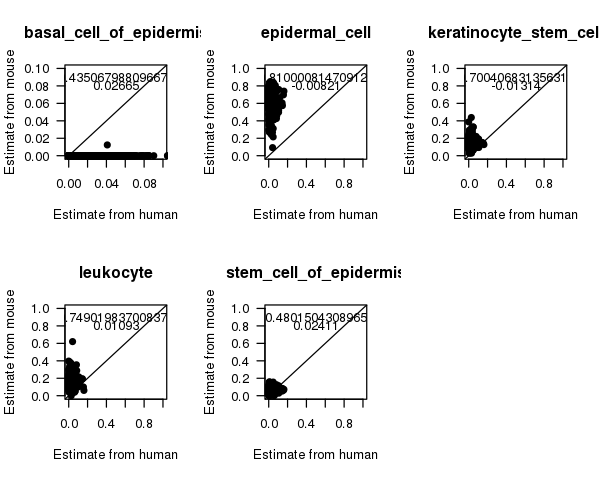

In [803]:

options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Cornified.Env_17 , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Cornified.Env_17 , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Cornified.Env_17 , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Cornified.Env_17 , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Cornified.Env_17 , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

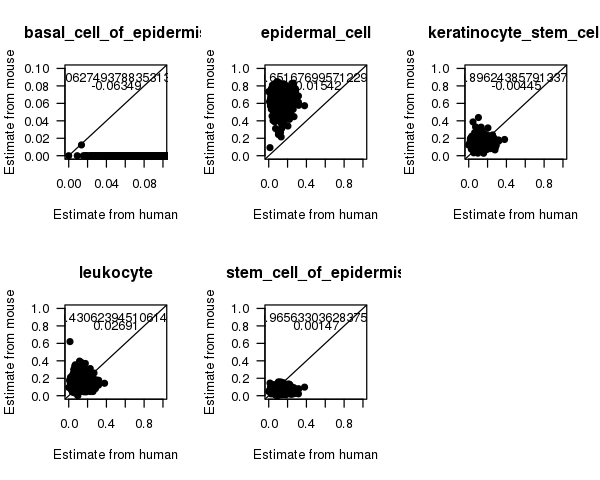

In [804]:

options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Fibroblast_0 , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Fibroblast_0 , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Fibroblast_0 , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Fibroblast_0 , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Fibroblast_0 , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

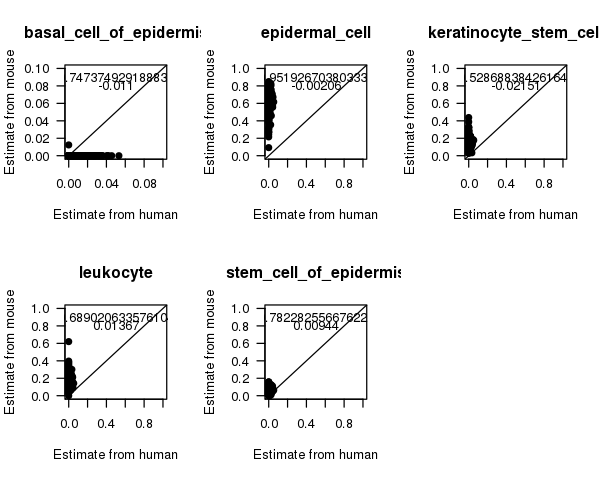

In [805]:

options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Fibroblast_3 , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Fibroblast_3 , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Fibroblast_3 , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Fibroblast_3 , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Fibroblast_3 , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

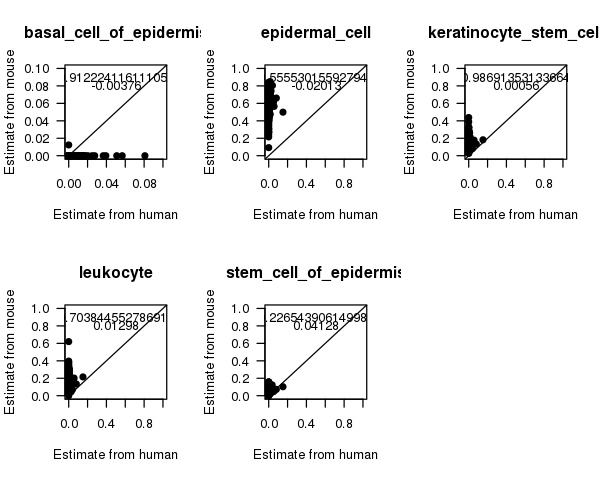

In [806]:

options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Fibroblast_4 , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Fibroblast_4 , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Fibroblast_4 , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Fibroblast_4 , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Fibroblast_4 , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

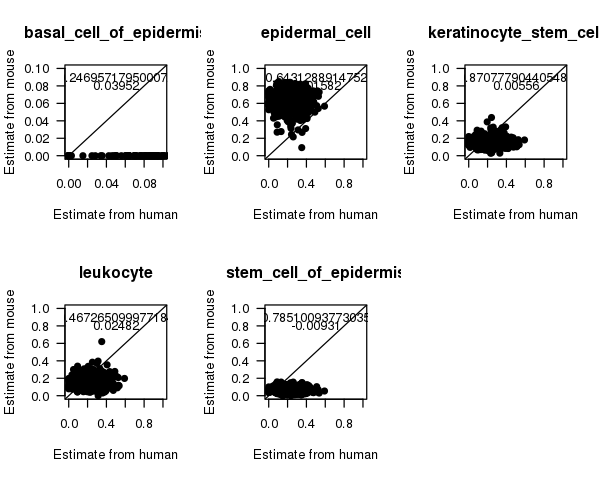

In [807]:

options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Keratinocyte_1 , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Keratinocyte_1 , mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Keratinocyte_1 , mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Keratinocyte_1 , mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Keratinocyte_1 , mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

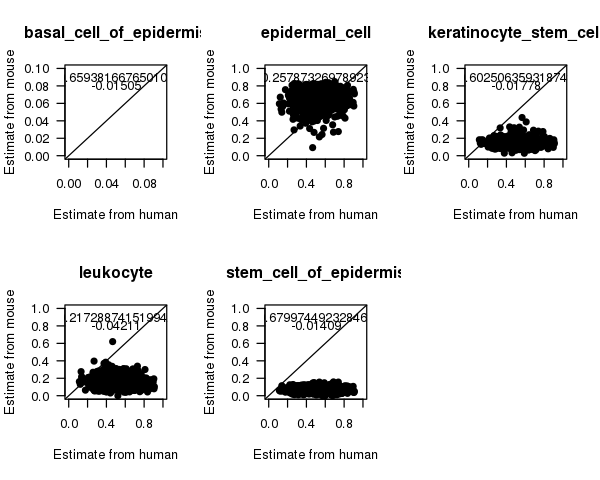

In [809]:

options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Keratinocyte_7_11 , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Keratinocyte_7_11, mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Keratinocyte_7_11, mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Keratinocyte_7_11, mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Keratinocyte_7_11, mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”

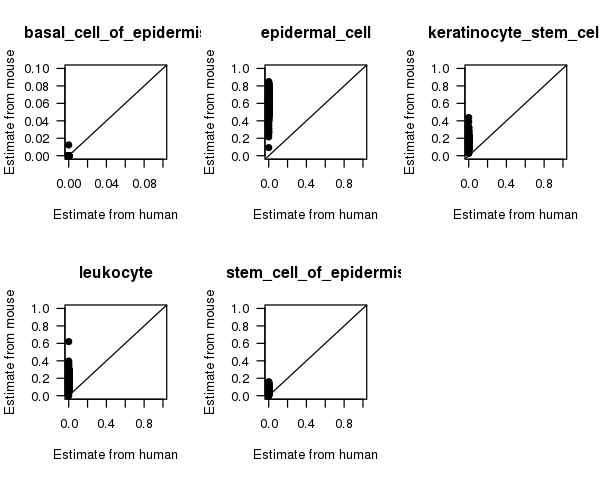

In [810]:

options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Keratinocyte_14 , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Keratinocyte_14, mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Keratinocyte_14, mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Keratinocyte_14, mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Keratinocyte_14, mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

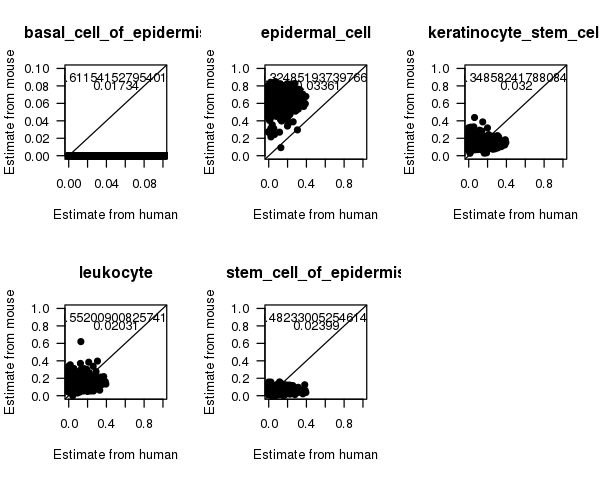

In [812]:

options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Keratinocyte_5 , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Keratinocyte_5, mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Keratinocyte_5, mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Keratinocyte_5, mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Keratinocyte_5, mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”

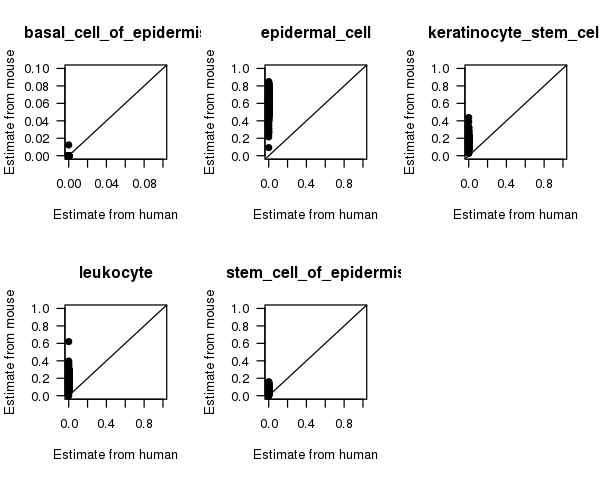

In [813]:

options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Lymphocyte_9 , mouse_estimates$basal_cell_of_epidermis, .1, "basal_cell_of_epidermis")
CorrPlotFrazer(human_estimates$Lymphocyte_9, mouse_estimates$epidermal_cell, 1, "epidermal_cell")
CorrPlotFrazer(human_estimates$Lymphocyte_9, mouse_estimates$keratinocyte_stem_cell, 1, "keratinocyte_stem_cell")
CorrPlotFrazer(human_estimates$Lymphocyte_9, mouse_estimates$leukocyte, 1, "leukocyte")
CorrPlotFrazer(human_estimates$Lymphocyte_9, mouse_estimates$stem_cell_of_epidermis, 1, "stem_cell_of_epidermis")

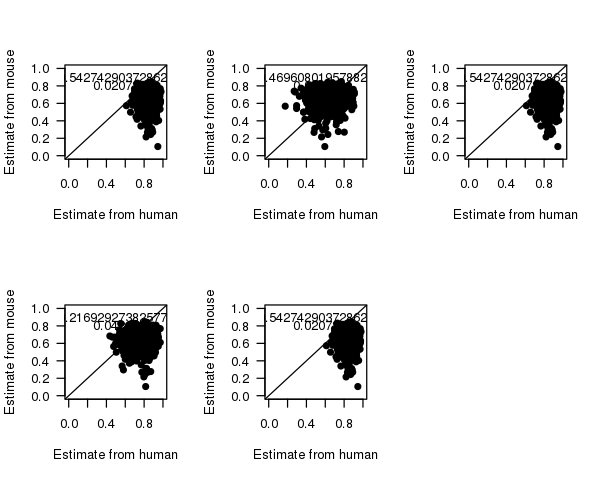

In [815]:

options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Keratinocyte_1 + human_estimates$Keratinocyte_5 + 
               human_estimates$Keratinocyte_7_11,
               mouse_estimates$basal_cell_of_epidermis+ mouse_estimates$epidermal_cell, 1, "")
               
CorrPlotFrazer(human_estimates$Keratinocyte_7_11 + human_estimates$Keratinocyte_5,
               mouse_estimates$basal_cell_of_epidermis+ mouse_estimates$epidermal_cell, 1, "")               

CorrPlotFrazer(human_estimates$Keratinocyte_1 + human_estimates$Keratinocyte_5 + 
               human_estimates$Keratinocyte_7_11,
               mouse_estimates$basal_cell_of_epidermis+ mouse_estimates$epidermal_cell, 1, "")

CorrPlotFrazer(human_estimates$Keratinocyte_1 + 
               human_estimates$Keratinocyte_7_11,
               mouse_estimates$basal_cell_of_epidermis+ mouse_estimates$epidermal_cell, 1, "")


CorrPlotFrazer(human_estimates$Keratinocyte_1 + human_estimates$Keratinocyte_7_11 + human_estimates$Keratinocyte_5 ,
               mouse_estimates$basal_cell_of_epidermis+ mouse_estimates$epidermal_cell, 1, "")

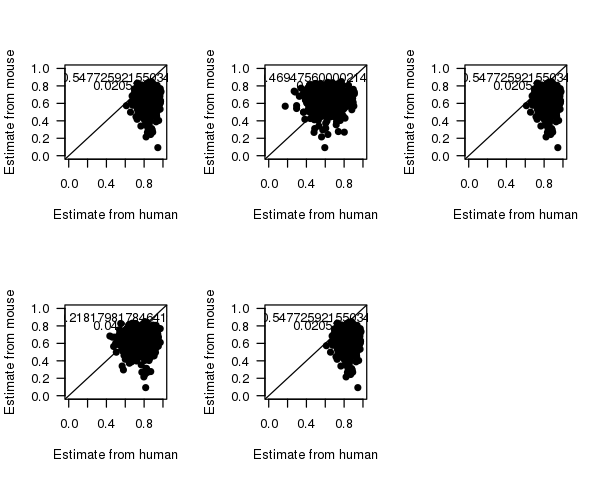

In [816]:

options(repr.plot.width = 5, repr.plot.height = 4)
par(mfrow = c(2,3))
CorrPlotFrazer(human_estimates$Keratinocyte_1 + human_estimates$Keratinocyte_5 + 
               human_estimates$Keratinocyte_7_11,
               mouse_estimates$epidermal_cell, 1, "")
               
CorrPlotFrazer(human_estimates$Keratinocyte_7_11 + human_estimates$Keratinocyte_5,
               mouse_estimates$epidermal_cell, 1, "")               

CorrPlotFrazer(human_estimates$Keratinocyte_1 + human_estimates$Keratinocyte_5 + 
               human_estimates$Keratinocyte_7_11,
               mouse_estimates$epidermal_cell, 1, "")

CorrPlotFrazer(human_estimates$Keratinocyte_1 + 
               human_estimates$Keratinocyte_7_11,
               mouse_estimates$epidermal_cell, 1, "")


CorrPlotFrazer(human_estimates$Keratinocyte_1 + human_estimates$Keratinocyte_7_11 + human_estimates$Keratinocyte_5 ,
               mouse_estimates$epidermal_cell, 1, "")

# integrate human epidermis and mouse

In [881]:
reference.list = list()
reference.list[["human_skin"]] <- human_skin_epidermis
reference.list[["mouse_skin"]] <- mouse_skin_newgenes

In [882]:
anchors <- FindIntegrationAnchors(object.list = reference.list, dims = 1:10)
integrated.epidermis <- IntegrateData(anchorset = anchors, dims = 1:10)
DefaultAssay(integrated.epidermis) <- "integrated"


Computing 2000 integration features
Scaling features for provided objects
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 7243 anchors
Filtering anchors
	Retained 3292 anchors
Extracting within-dataset neighbors
Merging dataset 2 into 1
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
Integrating data


In [883]:
# Run the standard workflow for visualization and clustering
integrated.epidermis <- ScaleData(integrated.epidermis, verbose = FALSE)
integrated.epidermis <- RunPCA(integrated.epidermis, npcs = 30, verbose = FALSE)
# UMAP and Clustering
integrated.epidermis <- RunUMAP(integrated.epidermis, reduction = "pca", dims = 1:15, min_dist = .05)

In [896]:
integrated.epidermis@meta.data[integrated.epidermis@meta.data$cell_ontology_class == "Keratinocyte", "cell_ontology_class"] = paste(integrated.epidermis@meta.data[integrated.epidermis@meta.data$cell_ontology_class == "Keratinocyte", "cell_ontology_class"], 
                                                                                           integrated.epidermis@meta.data[integrated.epidermis@meta.data$cell_ontology_class == "Keratinocyte", "res.0.6"],
                                                                                           sep = "_")

integrated.epidermis@meta.data[integrated.epidermis@meta.data$cell_ontology_class == "Fibroblast", "cell_ontology_class"] = paste(integrated.epidermis@meta.data[integrated.epidermis@meta.data$cell_ontology_class == "Fibroblast", "cell_ontology_class"], 
                                                                                           integrated.epidermis@meta.data[integrated.epidermis@meta.data$cell_ontology_class == "Fibroblast", "res.0.6"],
                                                                                           sep = "_")
integrated.epidermis@meta.data$free_annotation <- integrated.epidermis@meta.data$annotation 
integrated.epidermis@meta.data[is.na(integrated.epidermis@meta.data$free_annotation), "free_annotation"] = integrated.epidermis@meta.data[is.na(integrated.epidermis@meta.data$free_annotation), "cell_ontology_class"]

In [910]:
library(RColorBrewer)
n <- 16
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = sample(unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals))), 16)

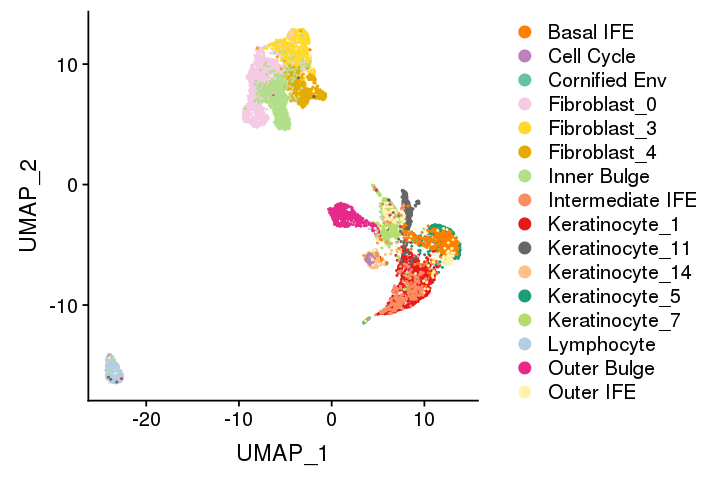

In [919]:
options(repr.plot.width = 6, repr.plot.height = 4)
DimPlot(integrated.epidermis, group.by = "free_annotation", cols = paste(col_vector, "", sep = ""), label = F)

# reanalyze mouse and human scRNA-seq

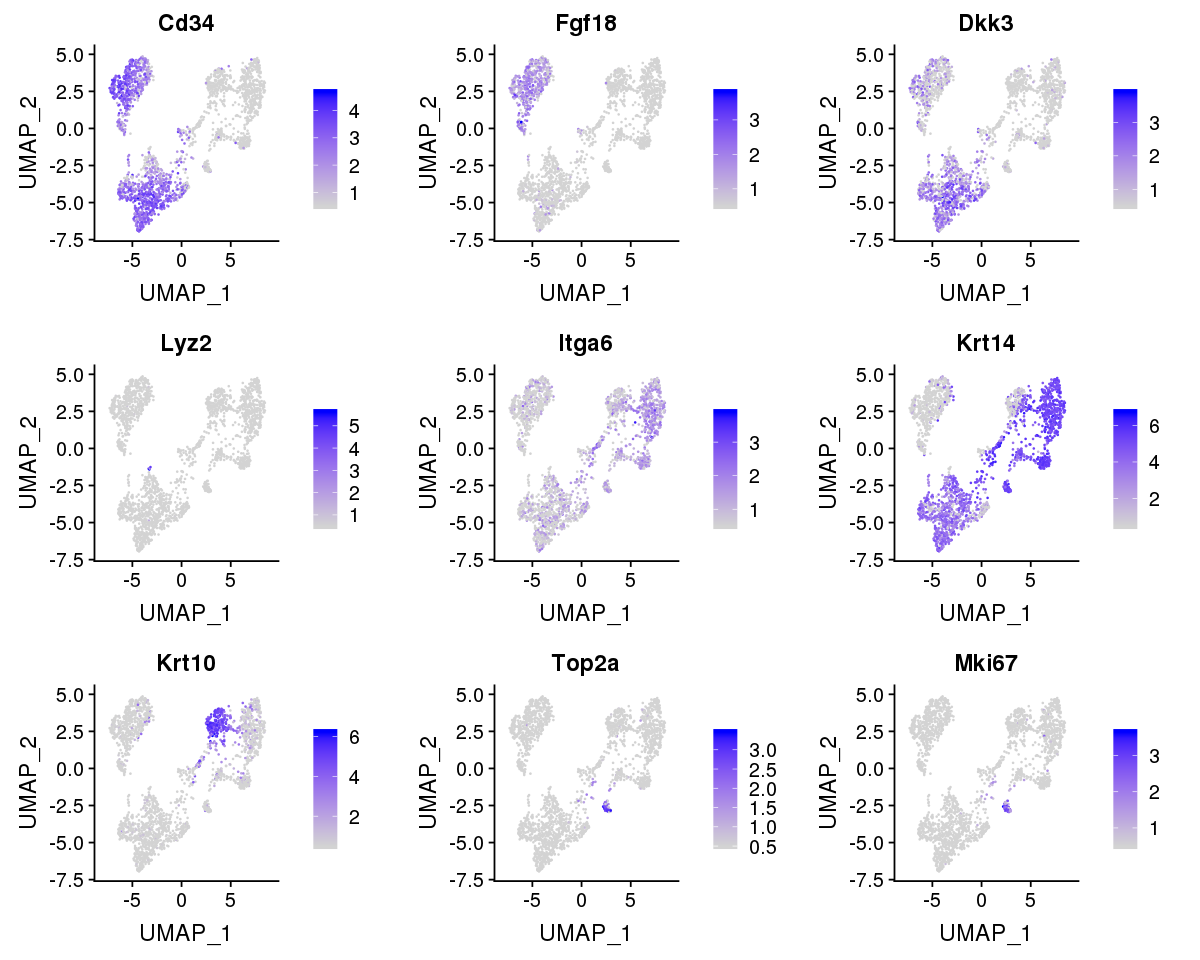

In [943]:
options(repr.plot.width = 10, repr.plot.height = 8)
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4200210/pdf/cshperspectmed-SKN-a013631.pdf
FeaturePlot(mouse_skin, features = c("Cd34", #bulge cells
                                     "Fgf18",#inner
                                     "Dkk3", #outer
                                     "Lyz2", #leukocytes
                                     "Itga6", #epidermal (broad)
                                     "Krt14", #basal
                                     "Krt10", # epidermal
                                     "Top2a", "Mki67"), #cell cycle (stem cell?)
            pt.size = .1, ncol = 3, min.cutoff = 0.5)

In [1265]:
# mouse_skin.reannotate = mouse_skin_newgenes
mouse_skin.reannotate = mouse_skin

In [1266]:
mouse_skin.reannotate@meta.data$reannotated_cell_names <- mouse_skin.reannotate@meta.data$cell_ontology_class

mouse_skin.reannotate@meta.data[mouse_skin.reannotate@meta.data$reannotated_cell_names == "keratinocyte stem cell", ]$reannotated_cell_names =
                                        mouse_skin.reannotate@meta.data[mouse_skin.reannotate@meta.data$reannotated_cell_names == "keratinocyte stem cell", ]$annotation

mouse_skin.reannotate@meta.data[mouse_skin.reannotate@meta.data$reannotated_cell_names == "Basal IFE", ]$reannotated_cell_names = "basal cell of epidermis"

mouse_skin.reannotate@meta.data[mouse_skin.reannotate@meta.data$reannotated_cell_names == "Intermediate IFE", ]$reannotated_cell_names = "epidermal cell"

mouse_skin.reannotate@meta.data[mouse_skin.reannotate@meta.data$reannotated_cell_names == "Outer IFE", ]$reannotated_cell_names = "basal cell of epidermis"

# mouse_skin.reannotate@meta.data[mouse_skin.reannotate@meta.data$res.0.5 == "4" &
#                                 (! mouse_skin.reannotate@meta.data$reannotated_cell_names == "epidermal cell" |
#                                    mouse_skin.reannotate@meta.data$reannotated_cell_names == "Inner Bulge" |
#                                    mouse_skin.reannotate@meta.data$reannotated_cell_names == "Outer Bulge" |
#                                    mouse_skin.reannotate@meta.data$reannotated_cell_names == "stem cell of the epidermis"), ]$reannotated_cell_names = "Outer IFE 1"



# mouse_skin.reannotate@meta.data[mouse_skin.reannotate@meta.data$res.0.5 == "5", ]$reannotated_cell_names = "Outer IFE 2"


# mouse_skin.reannotate@meta.data[ mouse_skin.reannotate@meta.data$annotation == "Intermediate IFE", ]$reannotated_cell_names = "epidermal cell"
# mouse_skin.reannotate@meta.data[ mouse_skin.reannotate@meta.data$annotation == "Inner Bulge", ]$reannotated_cell_names = "Inner Bulge"
# mouse_skin.reannotate@meta.data[ mouse_skin.reannotate@meta.data$annotation == "Outer Bulge", ]$reannotated_cell_names = "Outer Bulge"
# mouse_skin.reannotate@meta.data[ mouse_skin.reannotate@meta.data$cell_ontology_class == "leukocyte", ]$reannotated_cell_names = "leukocyte"

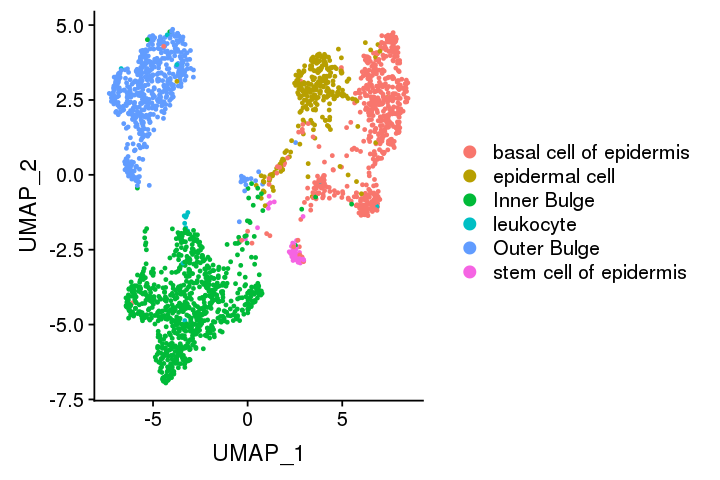

In [1267]:
options(repr.plot.width = 6, repr.plot.height = 4)
DimPlot(mouse_skin.reannotate, group.by = "reannotated_cell_names") #2 and 4 = basal 1 and basal 2 

In [1198]:
Idents(object = mouse_skin.reannotate) <- "reannotated_cell_names"
# Idents(object = mouse_skin.reannotate) <- "annotation"
# Idents(object = mouse_skin.reannotate) <- "cell_ontology_class"


In [1199]:
cts = unique(Idents(object = mouse_skin.reannotate))
cts

[1] Outer Bulge             Inner Bulge             basal cell of epidermis
[4] epidermal cell          Outer IFE 1             stem cell of epidermis 
[7] Outer IFE 2             leukocyte              
8 Levels: Outer Bulge Inner Bulge basal cell of epidermis ... leukocyte

In [1200]:
for( celltype in cts){
    celltype_name = gsub(" " , "_", celltype)
    assign(paste(celltype_name, "markers", sep = "_"), FindMarkers(mouse_skin.reannotate, ident.1 = celltype, test.use = "wilcox")) #, min.pct = 0.25))

}

In [1202]:
leukocyte_markers = leukocyte_markers[1:50,]

In [1203]:
markers = list( Inner_Bulge_markers,
                Outer_Bulge_markers,
                basal_cell_of_epidermis_markers,
                epidermal_cell_markers,
                stem_cell_of_epidermis_markers,
                leukocyte_markers,
                Outer_IFE_1_markers,
                Outer_IFE_2_markers
                )



names(markers) <- c("Inner_Bulge_markers",
                    "Outer_Bulge_markers",
                    "basal_cell_of_epidermis_markers",
                    "epidermal_cell_markers",
                    "stem_cell_of_epidermis_markers",
                    "leukocyte_markers",
                    "Outer_IFE_1_markers",
                    "Outer_IFE_2_markers")

In [1204]:
# markers = list( keratinocyte_stem_cell_markers,
#                 basal_cell_of_epidermis_markers,
#                 epidermal_cell_markers,
#                 stem_cell_of_epidermis_markers,
#                 leukocyte_markers
#                 )

# names(markers) <- c("keratinocyte_stem_cell_markers",
#                     "basal_cell_of_epidermis_markers",
#                     "epidermal_cell_markers",
#                     "stem_cell_of_epidermis_markers",
#                     "leukocyte_markers")

# markers = list( Inner_Bulge_markers,
#                 Intermediate_IFE_markers,
#                 Outer_Bulge_markers,
#                 Outer_IFE_markers,
#                 Basal_IFE_markers,
#                 Cell_Cycle_markers
#                 )

# names(markers) <- c("Inner_Bulge_markers",
#                     "Intermediate_IFE_markers",
#                     "Outer_Bulge_markers",
#                     "Outer_IFE_markers",
#                     "Basal_IFE_markers",
#                     "Cell_Cycle_markers")

In [1205]:
sig.df = data.frame(genes = NA, celltype = NA)

for( i in seq(1, length(markers))){
    
    ct = str_split_fixed(names(markers[i]), "_marke", 2)[,1]
    temp = as.data.frame(markers[[i]])
    temp = temp[order(temp$p_val_adj), ]
    temp = temp[temp$avg_logFC > 0.25 & temp$p_val_adj < 0.05, ]
    
    if(nrow(temp) > 200){ genes2add = rownames(temp[1:200,])}
    else{ genes2add = rownames(temp[1:nrow(temp),]) }

    sig.df.temp = data.frame(genes = genes2add, celltype = ct)
    sig.df = rbind(sig.df, sig.df.temp)
}

sig.df = sig.df[2:nrow(sig.df),]


In [1002]:
require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")

In [ ]:
convertMouseGeneList <- function(x){

    genesV2 = getLDS(attributes = c("mgi_symbol"), filters = "mgi_symbol", values = x , mart = mouse, attributesL = c("hgnc_symbol"), martL = human, uniqueRows=T)
    humanx <- unique(genesV2[, 2])
    return(humanx)
}

In [1206]:
sig.df$geneid = geneinfo[match(sig.df$genes, geneinfo$gene_name), "gene_id"]

sig.df$dup = duplicated(sig.df$genes)
sig.df = sig.df[sig.df$dup == F, ]
mouse_genes = read.table("../tables/Cibersort_input/Skin_mouse_signature_matrix_200.txt", header = T)

sig.df$inmouse = sig.df$geneid %in% mouse_genes$gene_id

table(sig.df$inmouse, sig.df$celltype)

       
        basal_cell_of_epidermis epidermal_cell Inner_Bulge leukocyte
  FALSE                      55             38         103        13
  TRUE                      145            117          97        37
       
        Outer_Bulge Outer_IFE_1 Outer_IFE_2 stem_cell_of_epidermis
  FALSE         110         104          89                     45
  TRUE           60           4          13                    155

In [1208]:

sig.avg_exp = AverageExpression(mouse_skin.reannotate, features = unique(sig.df$genes))

sig.avg_exp = sig.avg_exp$RNA

sig.avg_exp$gene_id = geneinfo[match(rownames(sig.avg_exp), geneinfo$gene_name), "gene_id"]

rownames(sig.avg_exp) <- NULL

signature_gene_matrix = sig.avg_exp[, c(ncol(sig.avg_exp), 1:(ncol(sig.avg_exp) - 1))]

Finished averaging RNA for cluster Outer Bulge
Finished averaging RNA for cluster Inner Bulge
Finished averaging RNA for cluster basal cell of epidermis
Finished averaging RNA for cluster epidermal cell
Finished averaging RNA for cluster Outer IFE 1
Finished averaging RNA for cluster stem cell of epidermis
Finished averaging RNA for cluster Outer IFE 2
Finished averaging RNA for cluster leukocyte


In [1209]:
head(sig.avg_exp)

Outer Bulge Inner Bulge basal cell of epidermis epidermal cell Outer IFE 1
1 0.2927701   11.946546   1.88357900              0.22284078     0.35482141 
2 0.3966402    5.013498   0.01954739              0.01233166     0.20657307 
3 2.2245204    6.647266   0.17057394              0.09188968     0.50218952 
4 3.7925164   17.723819   0.71209051              0.56606005     1.46720077 
5 0.6430944    7.574043   0.06805866              0.01456246     0.01534774 
6 0.5928746    2.377843   0.04557574              0.11276191     0.95489538 
  stem cell of epidermis Outer IFE 2 leukocyte gene_id           
1 1.01385877             1.32949064  5.8225558 ENSG00000113140.6 
2 0.06335675             0.13318757  0.3965460 ENSG00000118523.5 
3 0.33289914             0.20360508  1.2549659 ENSG00000050165.13
4 1.13479308             0.84725665  3.0734575 ENSG00000104332.7 
5 0.00610169             0.04930804  0.9789978 ENSG00000167916.4 
6 0.42313976             0.02286943  0.9552335 ENSG00000170017.8

In [1210]:
gtex_matrix = gtex[ rownames(gtex) %in% signature_gene_matrix$gene_id , colnames(gtex) %in% gtex_samples_skin]

gtex_matrix$gene_id = rownames(gtex_matrix)
gtex_matrix = gtex_matrix[, c(ncol(gtex_matrix), seq(1:(ncol(gtex_matrix)-1)))]
rownames(gtex_matrix) <- NULL

signature_gene_matrix = signature_gene_matrix[signature_gene_matrix$gene_id %in% gtex_matrix$gene_id, ]
gtex_matrix           = gtex_matrix[gtex_matrix$gene_id %in% signature_gene_matrix$gene_id, ]

table(gtex_matrix$gene_id %in% signature_gene_matrix$gene_id)
table(signature_gene_matrix$gene_id %in% gtex_matrix$gene_id)


write.table(signature_gene_matrix, file = "Skin_mouse_reanalyzed2_signature_matrix_100.txt", row.names = F, quote = F, sep = "\t")
write.table(gtex_matrix,           file = "GTEx_skin_signatureFromMousereanalyzed2_mixture_matrix_100.txt", row.names = F, quote = F, sep = "\t")


TRUE 
1058 


TRUE 
1058 

In [1220]:
gtex_skin = gtex_samples[gtex_samples$SMTSD %in% c("Skin - Not Sun Exposed (Suprapubic)", "Skin - Sun Exposed (Lower leg)"), "SAMPID"]

In [1248]:
mouse_estimates = read.csv("./CIBERSORT.Output_Job133_mousereanalyzed2.csv")
human_estimates = read.csv("./CIBERSORT.Output_Job131.csv")
human_estimates = human_estimates[human_estimates$Input.Sample %in% gtex_skin, ]
mouse_estimates = mouse_estimates[mouse_estimates$Input.Sample %in% gtex_skin, ]

human_estimates = human_estimates[human_estimates$Input.Sample %in% mouse_estimates$Input.Sample, ]

mouse_order = mouse_estimates[order( -mouse_estimates$epidermal.cell ), "Input.Sample"]
human_order = human_estimates[order(-human_estimates$Keratinocyte_14), "Input.Sample"]

In [1250]:
PlotWrapper <- function(humancell){
    
    
    options(repr.plot.width = 5, repr.plot.height = 4)
    par(mfrow = c(2,3))
    CorrPlotFrazer(human_estimates[, humancell] , mouse_estimates$epidermal.cell, 1, "epidermal.cell")
    CorrPlotFrazer(human_estimates[, humancell] , mouse_estimates$basal.cell.of.epidermis, 1, "basal.cell.of.epidermis")
    CorrPlotFrazer(human_estimates[, humancell] , mouse_estimates$Inner.Bulge, 1, "Inner.Bulge")
    CorrPlotFrazer(human_estimates[, humancell] , mouse_estimates$Outer.Bulge, 1, "Outer.Bulge")
    CorrPlotFrazer(human_estimates[, humancell] , mouse_estimates$stem.cell.of.epidermis, 1, "stem_cell_of_epidermis")
    CorrPlotFrazer(human_estimates[, humancell] , mouse_estimates$leukocyte, 1, "leukocyte")
    
    
}

[1] "Keratinocyte_5"


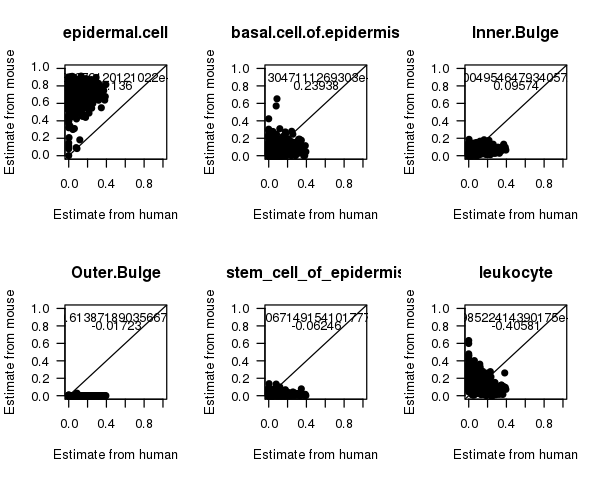

In [1251]:
cts = colnames(human_estimates[2:(ncol(human_estimates) - 3)])
print(cts[1])
PlotWrapper(cts[1])

[1] "Keratinocyte_1"


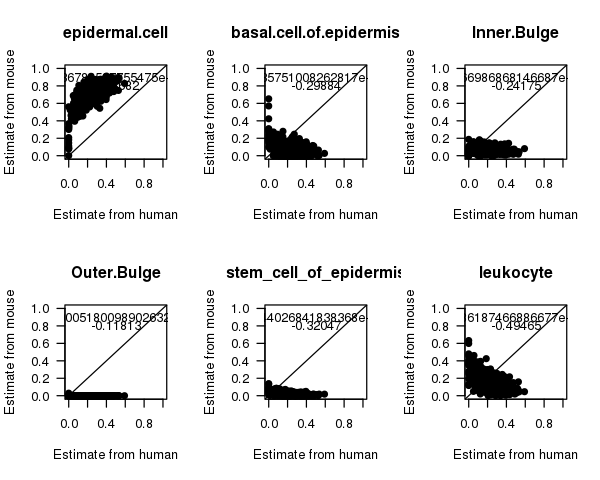

In [1252]:
print(cts[2])
PlotWrapper(cts[2])

[1] "Keratinocyte_7_11"


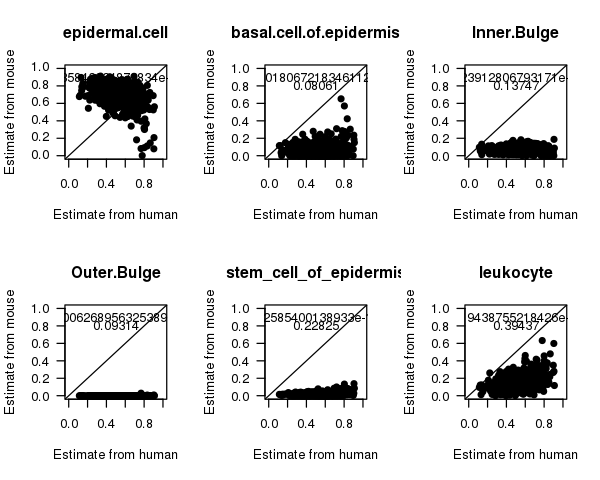

In [1253]:
print(cts[3])
PlotWrapper(cts[3])

[1] "Fibroblast_3"


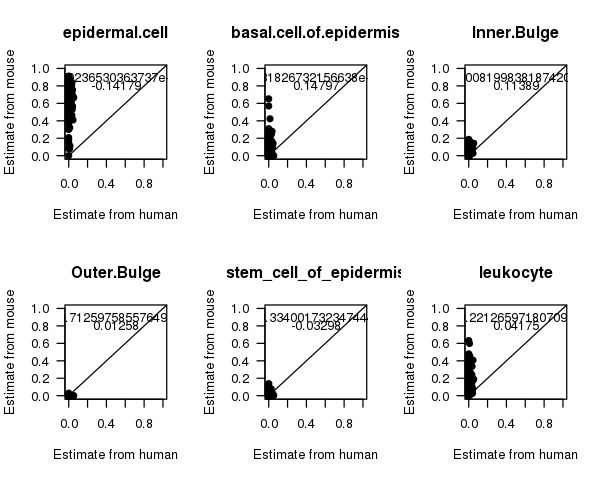

In [1254]:
print(cts[4])
PlotWrapper(cts[4])

[1] "Fibroblast_0"


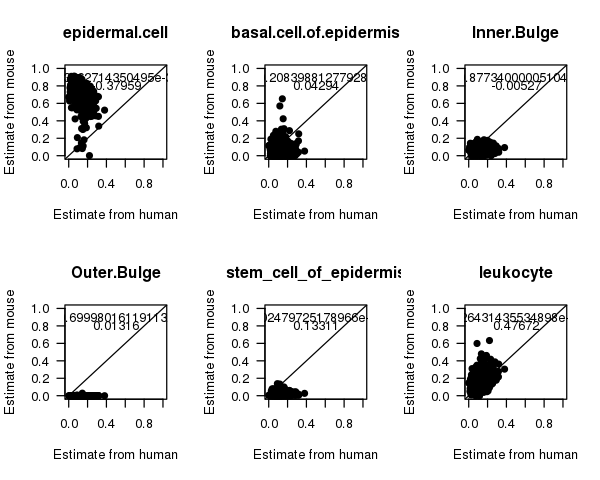

In [1255]:
print(cts[5])
PlotWrapper(cts[5])

[1] "Keratinocyte_14"


Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”

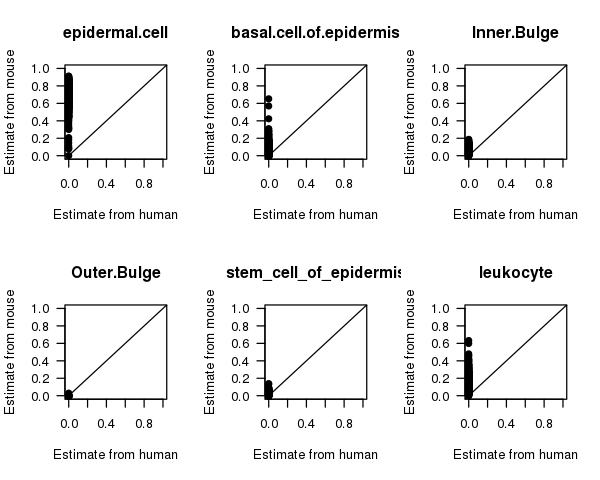

In [1256]:
print(cts[6])
PlotWrapper(cts[6])

[1] "Fibroblast_4"


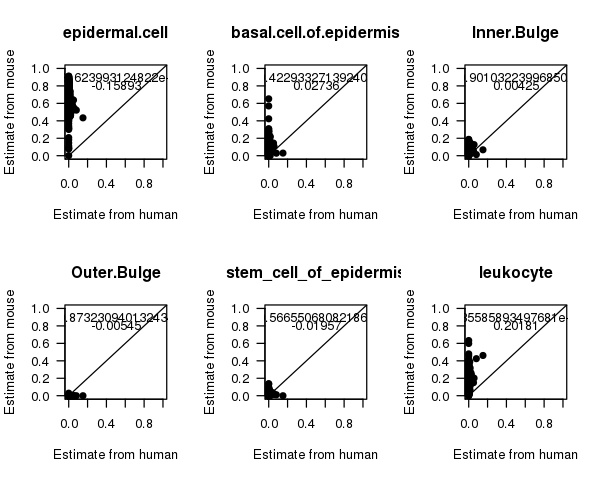

In [1257]:
print(cts[7])
PlotWrapper(cts[7])

[1] "Lymphocyte_9"


Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”Warning message in cor(x, y):
“the standard deviation is zero”

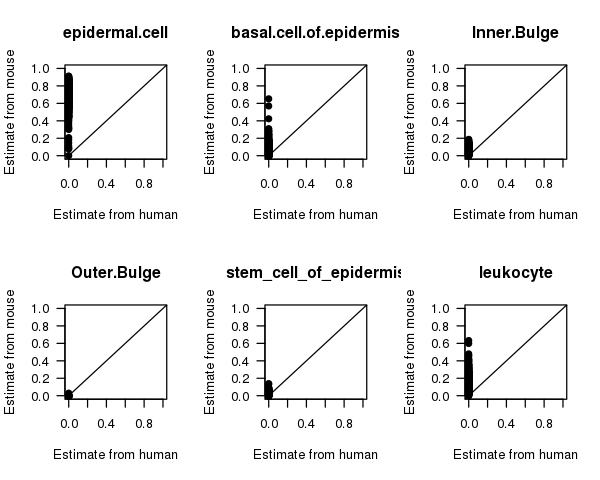

In [1258]:
print(cts[8])
PlotWrapper(cts[8])

[1] "Cornified.Env_17"


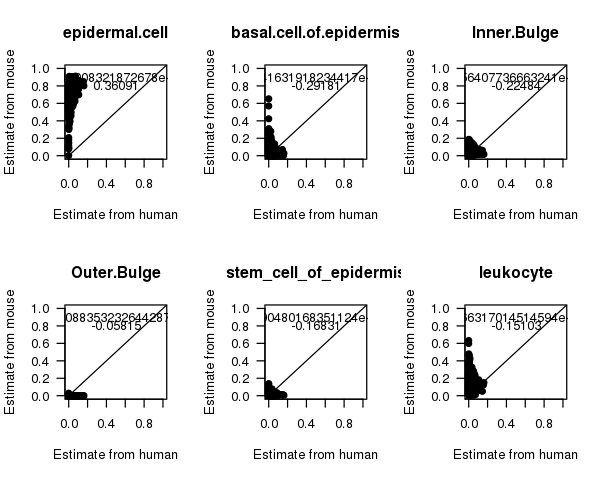

In [1259]:
print(cts[9])
PlotWrapper(cts[9])

In [1270]:
human_final_robj = human_skin_epidermis

# New Figures

In [7]:
library(Seurat)

## load robjs

In [1]:
load("../data/Robjs/human_skin_seurat.Robj", verbose = TRUE)
human_skin = tiss

Loading objects:
  tiss


In [3]:
load("../data/Robjs/human_epidermis_seurat.Robj", verbose = TRUE)
human_final_robj = tiss

Loading objects:
  tiss


In [5]:
load("../data/Robjs/mouse_skinreannotated_seurat.Robj", verbose = TRUE)
mouse_final_robj = tiss

Loading objects:
  tiss


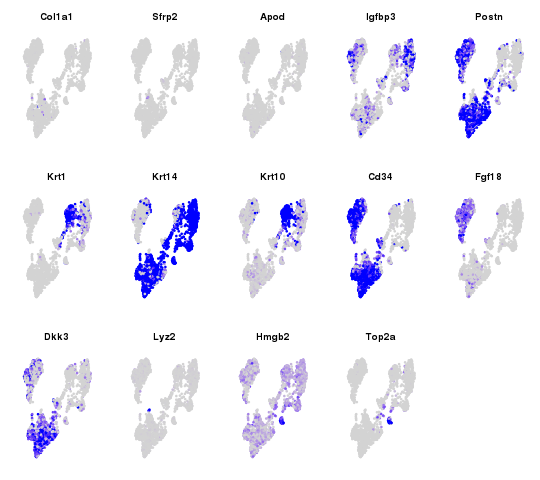

In [12]:
# Mouse expression of marker genes
options(repr.plot.width = 4.5, repr.plot.height = 4)
p <- FeaturePlot(mouse_final_robj, features = c(
                                                "Col1a1", #fibroblasts
                                                "Sfrp2", #fibroblasts
                                                "Apod", #fibroblasts
                                                "Igfbp3", #fibroblasts
                                                "Postn", #fibroblasts
    
                                                "Krt1", #keratinocytes
                                                "Krt14", #basal
                                                "Krt10", # epidermal
    
                                                "Cd34", #bulge cells
                                                "Fgf18",#inner
                                                "Dkk3", #outer

                                                "Lyz2", #leukocytes

                                                "Hmgb2", #epidermal (broad)
                                                "Top2a" #cell cycle (stem cell?)                                               
                                                ), 

                 pt.size = .1, min.cutoff = 0, max.cutoff = 2.5, combine = FALSE) 





for(i in 1:length(p)) {
  p[[i]] <- p[[i]] + NoLegend() + FontSize(main = 6) + NoAxes() 
}

cowplot::plot_grid(plotlist = p, ncol = 5)

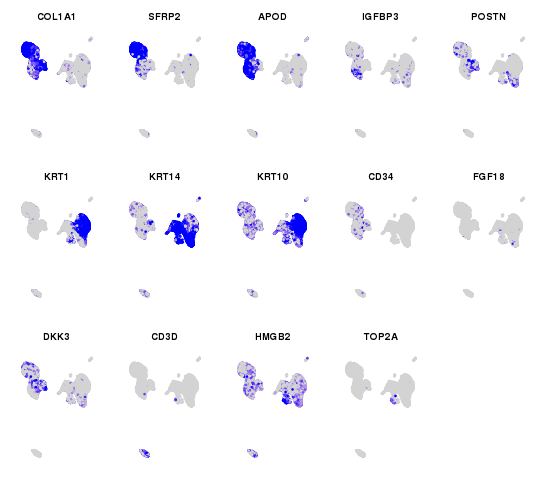

In [11]:
options(repr.plot.width = 4.5, repr.plot.height = 4)

p <- FeaturePlot(human_final_robj, features = c(
                                                "COL1A1", #fibroblasts
                                                "SFRP2", #fibroblasts
                                                "APOD", #fibroblasts
                                                "IGFBP3", #fibroblasts
                                                "POSTN", #fibroblasts
    
                                                "KRT1", #keratinocytes
                                                "KRT14", #basal
                                                "KRT10", # epidermal
    
                                                "CD34", #bulge cells
                                                "FGF18",#inner
                                                "DKK3", #outer
    
                                                "CD3D", #leukocytes

                                                "HMGB2", #stem cell
                                                "TOP2A" #cell cycle (stem cell?)
                                                  ),
            pt.size = .1, min.cutoff = 0, max.cutoff = 2.5, combine = FALSE)

for(i in 1:length(p)) {

    p[[i]] <- p[[i]] + NoLegend() + FontSize(main = 6) + NoAxes() 

}

cowplot::plot_grid(plotlist = p, ncol = 5)

In [13]:
human_cols <- c("#e33b6b", "#b5c200", "#edb02b", "#b04e09", "#09006b", "#366573", "#11bab2", "#75c1ff", "#3ead2f")
mouse_cols <- c("#a3a737", "#34ade3", "#b9a5cf", "#ef68a2", "#663d94", "orange")

In [14]:
human_skin_cols <- c("grey", "#e33b6b", "grey", "#b5c200", "#edb02b", "#b04e09", "#09006b", "#366573", "#11bab2", "#75c1ff", "#366573", "#3ead2f",
                    "grey", "grey", "grey", "grey", "grey", "grey", "grey")

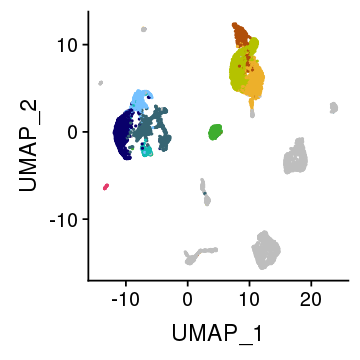

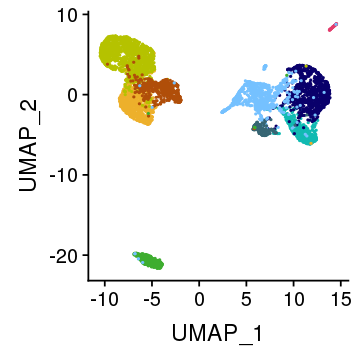

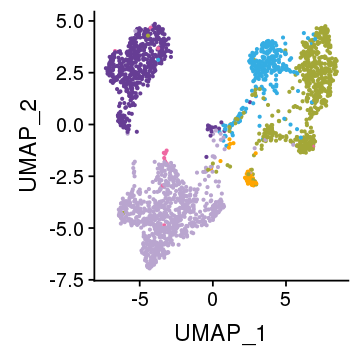

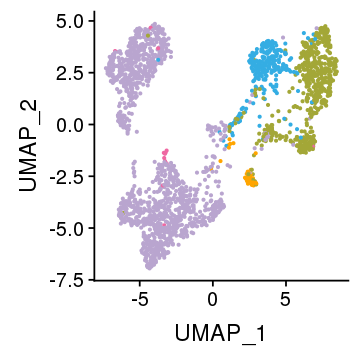

In [16]:
options(repr.plot.width = 3, repr.plot.height = 3)

DimPlot(human_skin, reduction = "umap", group.by = "celltype_cluster", label = F, pt.size = .25, cols = human_skin_cols) + NoLegend()
DimPlot(human_final_robj, reduction = "umap", group.by = "final_annotation", label = F, pt.size = .25, cols = human_cols) + NoLegend()

DimPlot(mouse_final_robj, group.by = "final_annotation", pt.size = .5, cols = mouse_cols) + NoLegend()
DimPlot(mouse_final_robj, group.by = "cell_ontology_class", pt.size = .5, cols = mouse_cols[c(1, 2, 3, 4, 6)]) + NoLegend()


In [17]:
PlotBarplotFrazer <- function(tiss, colors){
    
    par(mar = c(10, 5, 1, .5))
    counts = as.data.frame(table(tiss@meta.data$final_annotation))

    counts$fraction = (counts$Freq / sum(counts$Freq)) * 100
    counts = counts[order(counts$Var1),]
    counts$color <- colors
    counts = counts[order(counts$fraction),]
    



    barplot(counts$fraction, horiz = F, xlim = c(0, 60), names.arg = counts$Var1, las = 2, col = counts$color,
            border=NA, width = 3, ylab = "Fraction of cells")
    
    
}

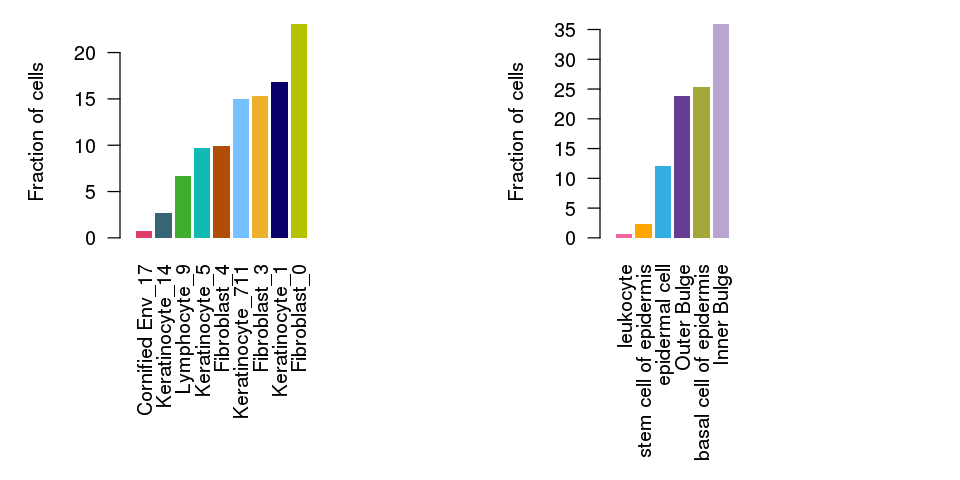

In [1609]:
options(repr.plot.width = 8, repr.plot.height = 4)


# pdf("./skin_cell_barplot.pdf", width = 8, height = 4)
par(mfrow = c(1,2))
PlotBarplotFrazer(human_final_robj, human_cols)
PlotBarplotFrazer(mouse_final_robj, mouse_cols)
# dev.off()

In [1383]:
mouse_colors = data.frame(celltypes = c('basal.cell.of.epidermis', 'epidermal.cell', 'Inner.Bulge',
                                       'leukocyte', 'Outer.Bulge', 'stem.cell.of.epidermis'),
                          colors =     mouse_cols)
               
human_colors = data.frame(celltypes = c('Cornified.Env_17', "Fibroblast_0", "Fibroblast_3",
                                       "Fibroblast_4", "Keratinocyte_1",
                                       "Keratinocyte_14", "Keratinocyte_5", "Keratinocyte_7_11",
                                       "Lymphocyte_9"),
                          colors =     human_cols)

In [1767]:
mouse_estimates = read.csv("./CIBERSORT_mouse_reannotated.csv")
human_estimates = read.csv("./CIBERSORT_human_epidermis.csv")

In [1776]:
mouse_order = mouse_estimates[order(-mouse_estimates$stem.cell.of.epidermis), "X"]

human_order = human_estimates[order(-human_estimates$Keratinocyte_14, -human_estimates$Keratinocyte_1), "X"]

In [1778]:
CiberBarFrazer <- function(ciber, colors, main0, ordered, legy, species){
    
    rownames(ciber) <- ciber$X
    ciber$X <- NULL
    ciber = ciber[, seq(1, (ncol(ciber) - 3))]
    ciber = ciber[ordered,]
    nsamples = nrow(ciber)
    ciber = as.data.frame(t(ciber) * 100)


    
    if( species == "human"){

#         rownames(ciber)  = factor(rownames(ciber), levels=c("Cornified.Env_17", "Keratinocyte_7_11", "Keratinocyte_1", "Keratinocyte_14", "Keratinocyte_5",
#                                      "Fibroblast_3", "Fibroblast_0", "Fibroblast_4",
#                                       "Lymphocyte_9"))
    
        ciber = ciber[c("Keratinocyte_14","Keratinocyte_1", "Keratinocyte_7_11",  "Keratinocyte_5",
                                     "Fibroblast_3", "Fibroblast_0", "Fibroblast_4",
                                      "Lymphocyte_9", "Cornified.Env_17"), ]
        ciber = ciber[,ordered]

    }
    
    if( species == "mouse"){
    
        ciber = ciber[rev(c("basal.cell.of.epidermis", "Outer.Bulge", "Inner.Bulge", "leukocyte",
                                     "epidermal.cell", "stem.cell.of.epidermis")), ]
        ciber = ciber[,ordered]

    }
    
    ciber$color = colors[ match(rownames(ciber), colors$celltypes),  "colors"]

    barplot(as.matrix(ciber[, seq(1, (ncol(ciber) - 1))]), las = 2, col = ciber$color, border=NA, names.arg = rep("", ncol(ciber) - 1), 
           ylab = "Fraction clusters", main = main0)

    text(nsamples * .05, legy + 3, paste("n = ", nsamples, sep = ""), pos = 4)

    legend(nsamples * .05, legy, gsub("_", " ", colors$celltypes), bty = "n",
           pch = rep(22, nrow(colors)),
           pt.cex = rep(1.5, nrow(colors)),
           pt.bg = colors$colors )
    

    
}





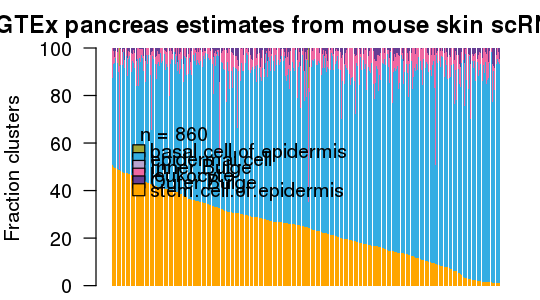

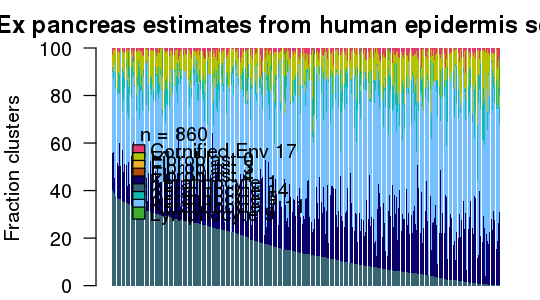

In [1784]:
options(repr.plot.width = 4.5, repr.plot.height = 2.5)
# pdf("./pidermis_cellular_estimates_barplot.pdf", height = 2.5, width = 4.5)
par(mar = c(0.5, 4, 2, 1))

CiberBarFrazer(mouse_estimates, mouse_colors, "GTEx pancreas estimates from mouse skin scRNA-seq", mouse_order, 60, "mouse")
CiberBarFrazer(human_estimates, human_colors, "GTEx pancreas estimates from human epidermis scRNA-seq", human_order, 60, "human")

# dev.off()

In [1553]:
library(corrplot)
library(stringr)
library(RColorBrewer)

In [1557]:
CorSpeciesFrazer <- function(human, mouse){
    
    rownames(human) <- human$X
    human$X <- NULL
    colnames(human) <- paste(colnames(human), "human", sep = "_")
    
    rownames(mouse) <- mouse$X
    mouse$X <- NULL
    colnames(mouse) <- paste(colnames(mouse), "mouse", sep = "_")
    
    m <- cbind(human, mouse)
    
    
    m$Lymphocyte_human <- NULL
#     m$ductal_human <- NULL
#     m$schwann_human <- NULL
    
    
    return(m)
}

In [1734]:
HeatmapSpeciesFrazer <- function(human, mouse){
    
    m = CorSpeciesFrazer(human, mouse)
    res1 <- cor.mtest(m)
    m <- cor(m)

    rownames(res1$p) <- rownames(m)
    colnames(res1$p) <- colnames(m)

    m <- m[  grep("mouse", rownames(m)),]
    m <- m[, grep("human", colnames(m)) ]
    res1$p <- res1$p[  grep("mouse", rownames(res1$p)),]
    res1$p <- res1$p[, grep("human", colnames(res1$p)) ]
    
    rownames(m) = str_split_fixed(rownames(m), "_mouse", 2)[,1]
    colnames(m) = str_split_fixed(colnames(m), "_human", 2)[,1]

    
    rownames(m) = gsub("_", " ", rownames(m))
    colnames(m) = gsub("_", " ", colnames(m))
    
    
#     corrplot(m, method = "color", cl.ratio = 0.5, p.mat = res1$p, sig.level = c(10e-100, 10e-25, 10e-15), pch.cex = 2, insig = "label_sig", pch.col = "white")#,
    corrplot(m, method = "color", cl.ratio = 0.5, p.mat = res1$p, sig.level = c(10e-100, 10e-50, 10e-20), pch.cex = 1.25, insig = "label_sig", pch.col = "white", cl.pos = "n")#,
#              col = rev(colorRampPalette(c("#67001F", "#B2182B", "#D6604D", "#F4A582",
#                               "#FDDBC7", "#FFFFFF", "#D1E5F0", "#92C5DE",
#                               "#4393C3", "#2166AC", "#053061"))(200)))
    
    return(m)
    
}

In [1575]:
human_estimates_cor <- human_estimates
human_estimates_cor$Keratinocyte_collapsed <- human_estimates_cor$Keratinocyte_1 + human_estimates_cor$Keratinocyte_14 + human_estimates_cor$Keratinocyte_5 + human_estimates_cor$Keratinocyte_7_11
human_estimates_cor$Fibroblast_collapsed   <- human_estimates_cor$Fibroblast_0   + human_estimates_cor$Fibroblast_3    + human_estimates_cor$Fibroblast_4

In [1567]:
# mouse_estimates_cor <- mouse_estimates_cor
# mouse_estimates_cor$Keratinocyte_stem_cell_collapsed <- human_estimates_cor$Keratinocyte_1 + human_estimates_cor$Keratinocyte_14 + human_estimates_cor$Keratinocyte_5 + human_estimates_cor$Keratinocyte_7_11


In [1737]:
options(repr.plot.width = 5, repr.plot.height =3)
pdf("./estimation_correlation_heatmap.pdf", height = 3, width = 5)
HeatmapSpeciesFrazer(human_estimates_cor[, !colnames(human_estimates_cor) %in% c("P.value", "Pearson.Correlation", "RMSE")],
                     mouse_estimates[,     !colnames(mouse_estimates) %in% c("P.value", "Pearson.Correlation", "RMSE")])
dev.off()

Keratinocyte 5 Keratinocyte 1 Keratinocyte 7 11
Outer.Bulge             -0.02397231    -0.07040152     0.02066414      
Inner.Bulge             -0.07969031    -0.34363370     0.34135562      
basal.cell.of.epidermis -0.05053639    -0.18363190     0.11075479      
epidermal.cell           0.22999991     0.53114885     0.11839954      
stem.cell.of.epidermis  -0.14971708    -0.28401844    -0.34835880      
leukocyte               -0.18178923    -0.49288895     0.38905411      
                        Fibroblast 3 Fibroblast 0 Keratinocyte 14 Fibroblast 4
Outer.Bulge             -0.018929750 -0.023524300  0.06178445     -0.006270400
Inner.Bulge              0.049575394  0.084355525 -0.08815959      0.014742987
basal.cell.of.epidermis  0.007475930  0.004957349  0.03962218     -0.008442738
epidermal.cell          -0.009791308  0.044300763 -0.77483643     -0.079603312
stem.cell.of.epidermis  -0.036384053 -0.237692929  0.88746290     -0.039854159
leukocyte                0.093198590  0.433996239 -0.15558065      0.298450924
                        Lymphocyte 9 Cornified.Env 17 Keratinocyte collapsed
Outer.Bulge             -0.009446897  0.004011188      0.026690908          
Inner.Bulge             -0.016065208 -0.251568301      0.006125608          
basal.cell.of.epidermis  0.068923436 -0.092851945     -0.010677653          
epidermal.cell          -0.072741634  0.288730604     -0.081050533          
stem.cell.of.epidermis   0.056719640 -0.152248958      0.233314264          
leukocyte                0.038754370 -0.249580242     -0.363028908          
                        Fibroblast collapsed
Outer.Bulge             -0.026138459        
Inner.Bulge              0.090681172        
basal.cell.of.epidermis  0.004681594        
epidermal.cell           0.032616207        
stem.cell.of.epidermis  -0.243572327        
leukocyte                0.476031312

png 
  2

In [1906]:
options(repr.plot.width = 10, repr.plot.height =5)

pdf("estimate_cell_type_correlation_scatter.pdf", height = 5, width = 10)

par(mfrow = c(1,2))
plot(human_estimates_cor$Keratinocyte_14, mouse_estimates$stem.cell.of.epidermis, pch = 19, las = 2)
lines(c(0:1), c(0:1))
cor(human_estimates_cor$Keratinocyte_14, mouse_estimates$stem.cell.of.epidermis)

plot(human_estimates_cor$Keratinocyte_1 + human_estimates_cor$Keratinocyte_5 + human_estimates_cor$Keratinocyte_7_11, mouse_estimates$epidermal.cell, pch = 19, las = 2, xlim = c(0,1))
lines(c(0:1), c(0:1))
cor(human_estimates_cor$Keratinocyte_1 + human_estimates_cor$Keratinocyte_5 + human_estimates_cor$Keratinocyte_7_11, mouse_estimates$epidermal.cell)
dev.off()

[1] 0.8874629

[1] 0.7360086

png 
  2